# Description

In this project, we will be predicting a full year worth of sales for various fictitious learning modules from different fictitious Kaggle-branded stores in different (real!) countries. This dataset is completely synthetic, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. You are given the task of predicting sales during for year 2022.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings('ignore')

ordinal_encoder = OrdinalEncoder()

country_label_encoder = LabelEncoder()
store_label_encoder = LabelEncoder()
product_label_encoder = LabelEncoder()

data = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [628]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        136950 non-null  int64 
 1   date      136950 non-null  object
 2   country   136950 non-null  object
 3   store     136950 non-null  object
 4   product   136950 non-null  object
 5   num_sold  136950 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.3+ MB


In [164]:
test.head()

id        date    country         store  \
0  136950  2022-01-01  Argentina  Kaggle Learn   
1  136951  2022-01-01  Argentina  Kaggle Learn   
2  136952  2022-01-01  Argentina  Kaggle Learn   
3  136953  2022-01-01  Argentina  Kaggle Learn   
4  136954  2022-01-01  Argentina  Kaggle Learn   

                                          product  
0               Using LLMs to Improve Your Coding  
1                   Using LLMs to Train More LLMs  
2  Using LLMs to Win Friends and Influence People  
3      Using LLMs to Win More Kaggle Competitions  
4                      Using LLMs to Write Better

In [165]:
data.head()

id        date    country         store  \
0   0  2017-01-01  Argentina  Kaggle Learn   
1   1  2017-01-01  Argentina  Kaggle Learn   
2   2  2017-01-01  Argentina  Kaggle Learn   
3   3  2017-01-01  Argentina  Kaggle Learn   
4   4  2017-01-01  Argentina  Kaggle Learn   

                                          product  num_sold  
0               Using LLMs to Improve Your Coding        63  
1                   Using LLMs to Train More LLMs        66  
2  Using LLMs to Win Friends and Influence People         9  
3      Using LLMs to Win More Kaggle Competitions        59  
4                      Using LLMs to Write Better        49

In [166]:
data['date'] = pd.to_datetime(data['date'])
test['date'] = pd.to_datetime(test['date'])

In [168]:
print(data['date'].min())
print(data['date'].max())

2017-01-01 00:00:00
2021-12-31 00:00:00


In [167]:
print(test['date'].min())
print(test['date'].max())

2022-01-01 00:00:00
2022-12-31 00:00:00


In [169]:
data['date'].value_counts()

2017-01-01    75
2020-05-11    75
2020-05-09    75
2020-05-08    75
2020-05-07    75
              ..
2018-08-29    75
2018-08-28    75
2018-08-27    75
2018-08-26    75
2021-12-31    75
Name: date, Length: 1826, dtype: int64

In [170]:
data[data['date'] == '2017-01-01'][data['product'] == 'Using LLMs to Improve Your Coding']

id       date    country         store                            product  \
0    0 2017-01-01  Argentina  Kaggle Learn  Using LLMs to Improve Your Coding   
5    5 2017-01-01  Argentina  Kaggle Store  Using LLMs to Improve Your Coding   
10  10 2017-01-01  Argentina     Kagglazon  Using LLMs to Improve Your Coding   
15  15 2017-01-01     Canada  Kaggle Learn  Using LLMs to Improve Your Coding   
20  20 2017-01-01     Canada  Kaggle Store  Using LLMs to Improve Your Coding   
25  25 2017-01-01     Canada     Kagglazon  Using LLMs to Improve Your Coding   
30  30 2017-01-01    Estonia  Kaggle Learn  Using LLMs to Improve Your Coding   
35  35 2017-01-01    Estonia  Kaggle Store  Using LLMs to Improve Your Coding   
40  40 2017-01-01    Estonia     Kagglazon  Using LLMs to Improve Your Coding   
45  45 2017-01-01      Japan  Kaggle Learn  Using LLMs to Improve Your Coding   
50  50 2017-01-01      Japan  Kaggle Store  Using LLMs to Improve Your Coding   
55  55 2017-01-01      Japan     Kagglazon  Using LLMs to Improve Your Coding   
60  60 2017-01-01      Spain  Kaggle Learn  Using LLMs to Improve Your Coding   
65  65 2017-01-01      Spain  Kaggle Store  Using LLMs to Improve Your Coding   
70  70 2017-01-01      Spain     Kagglazon  Using LLMs to Improve Your Coding   

    num_sold  
0         63  
5         88  
10       340  
15       202  
20       274  
25      1041  
30        92  
35       132  
40       501  
45       167  
50       270  
55       938  
60       122  
65       177  
70       724

In [13]:
countries = sorted(list(set(data['country'])))
products = sorted(list(set(data['product'])))
stores = sorted(list(set(data['store'])))

len(countries) * len(products) * len(stores)

75

# distribution of sales across each country, product and store

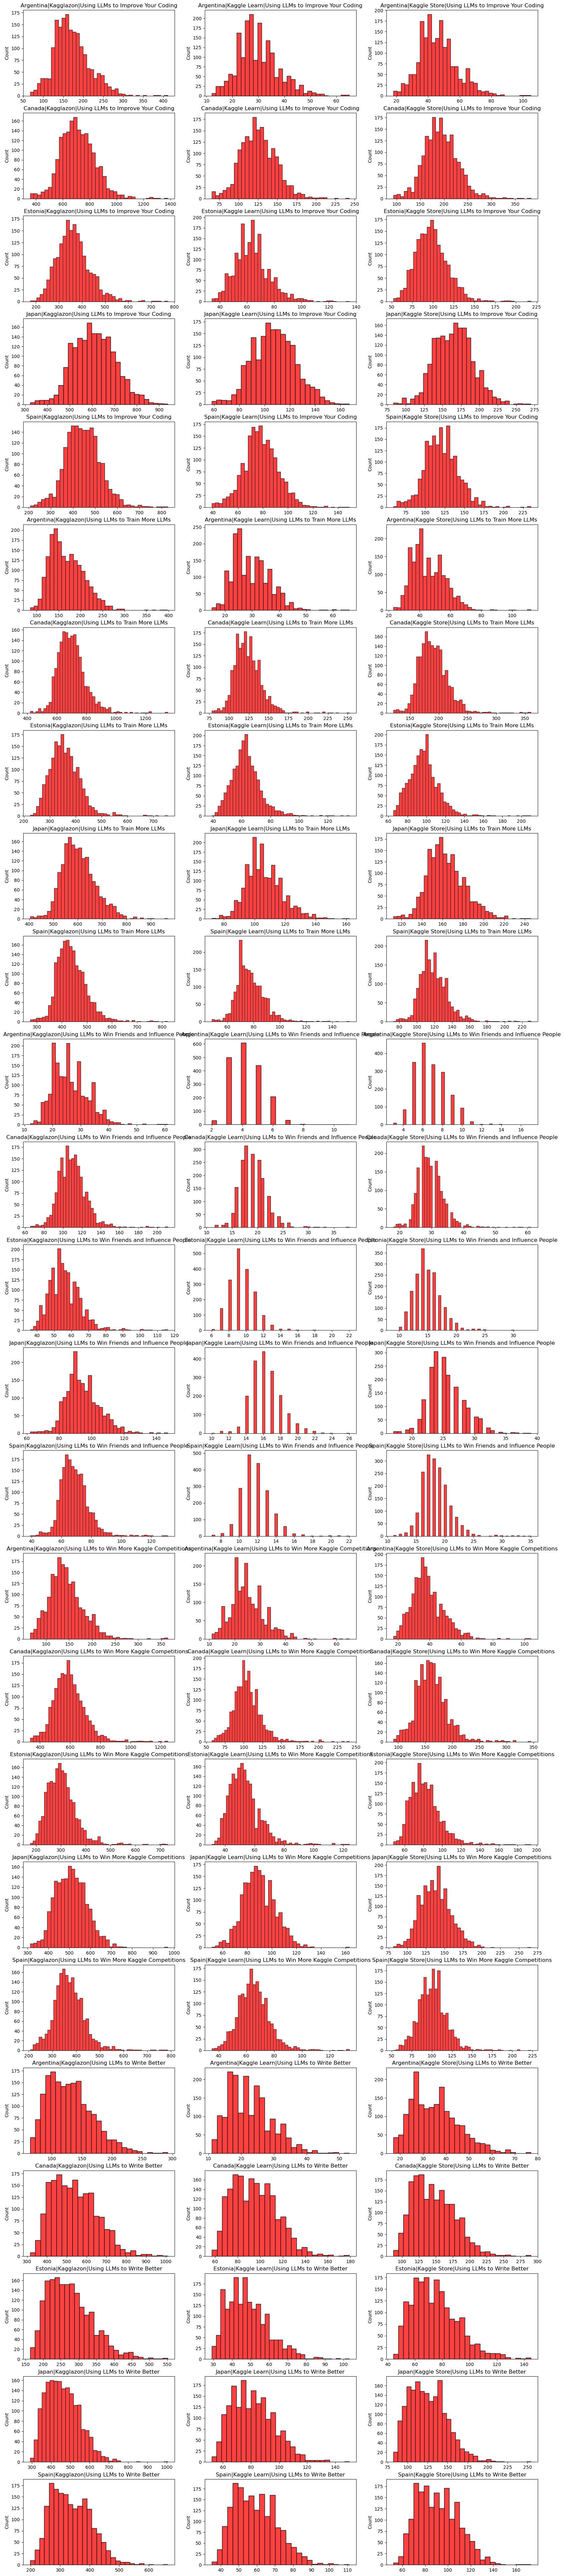

In [177]:
subplots = 25
_,ax = plt.subplots(subplots,3,figsize=(20,100))
stat = pd.DataFrame()
i=0
for product in products:
    for country in countries:
        k = 0
        for store in stores:
            diff = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]['num_sold'].reset_index(drop=True)
            sns.histplot(diff, ax=ax[i,k], color='red')
            ax[i,k].set_title(f"{country}|{store}|{product}")
            ax[i,k].set_xlabel('')
            k+=1
        i+=1
plt.show()

# selling of product by country

<Axes: >

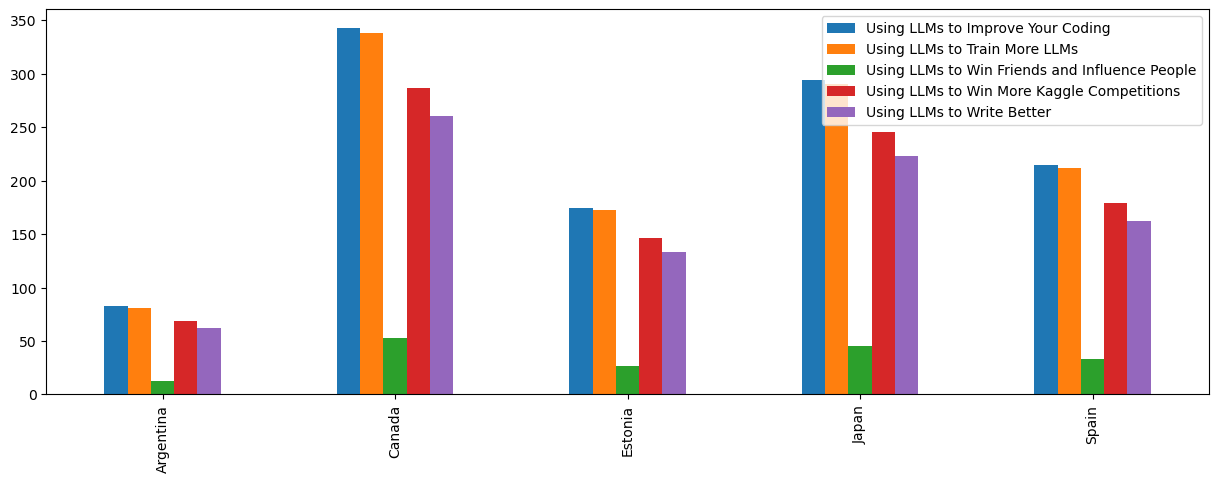

In [172]:
col = 'country'
res = pd.DataFrame(data[[col,'product','num_sold']].groupby([col,'product']).mean().values.reshape(len(countries),len(products)), columns=products).set_index([countries])
fig, ax = plt.subplots(figsize=(15, 5))
res.plot(kind='bar', ax=ax)

# from above grapah we can conclude that, for each country product sales is different

<Axes: >

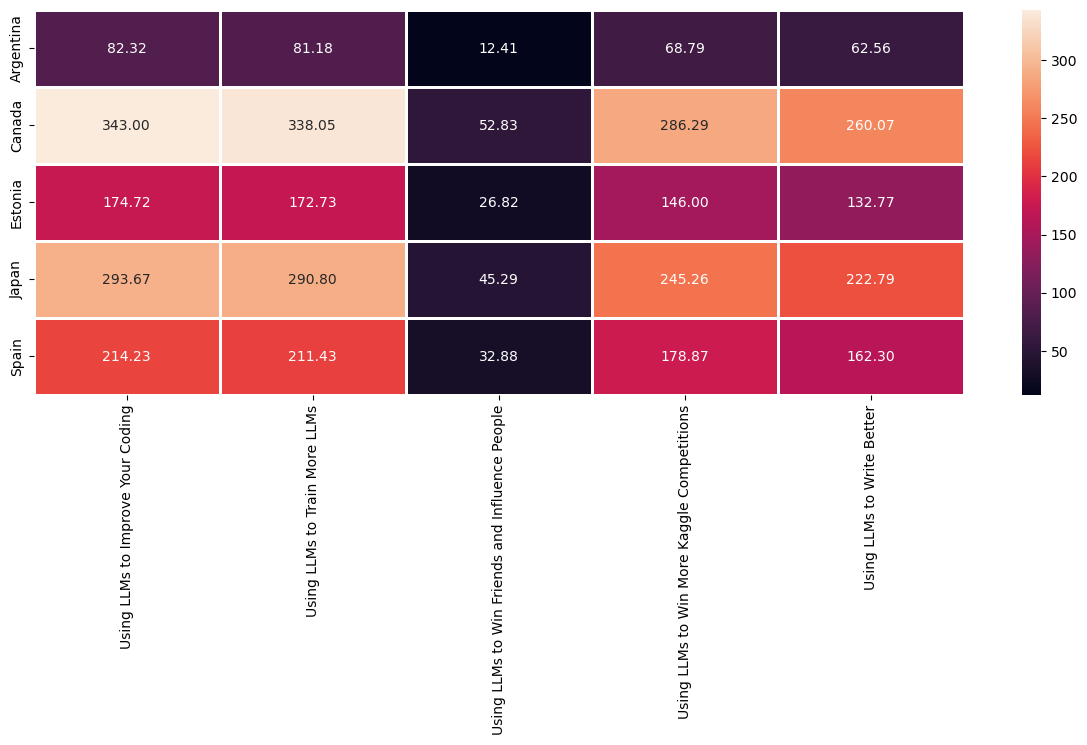

In [178]:
plt.figure(figsize=(15,5))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# from above grapah it is clearly evedent that canada using the products the most and then Japan

<Axes: >

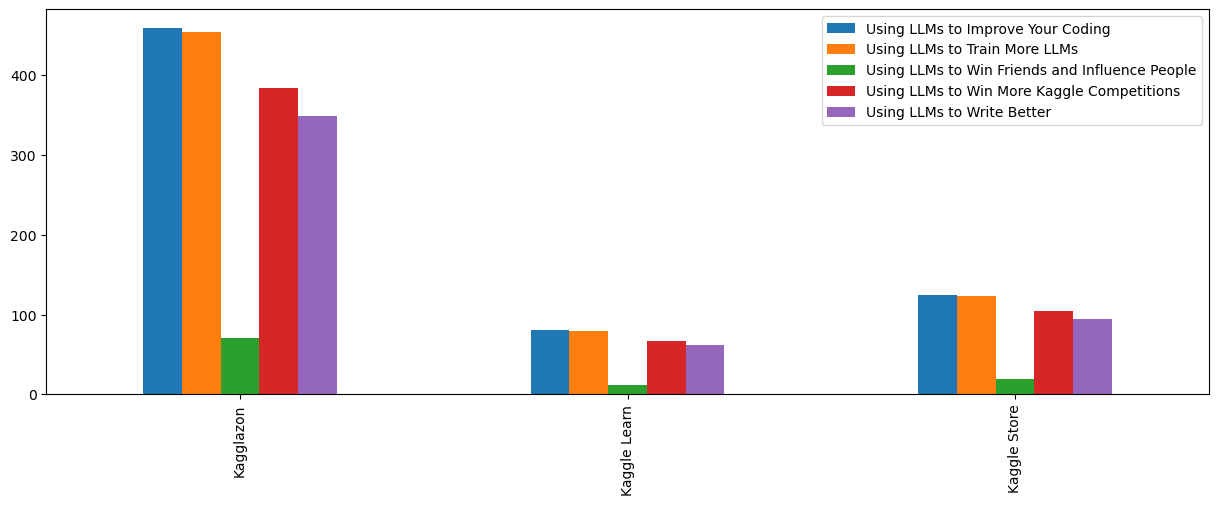

In [179]:
col = 'store'
res = pd.DataFrame(data[[col,'product','num_sold']].groupby([col,'product']).mean().values.reshape(len(stores),len(products)), columns=products).set_index([stores])
fig, ax = plt.subplots(figsize=(15, 5))
res.plot(kind='bar', ax=ax)

# Product sales in each store is different

<Axes: >

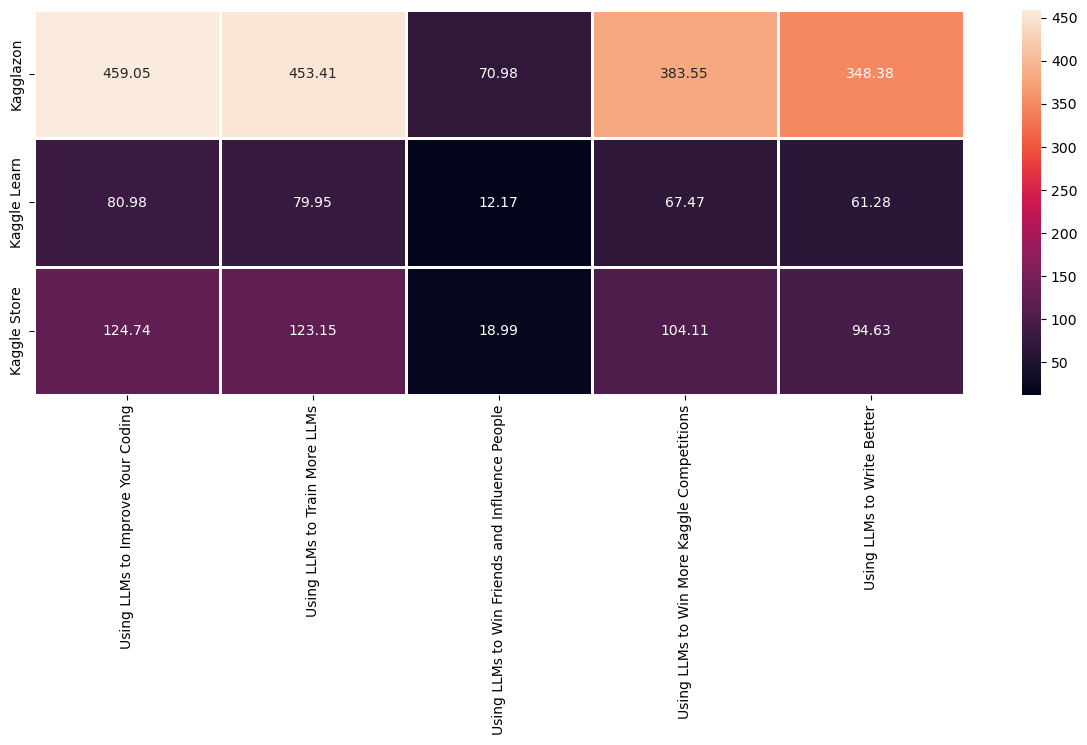

In [180]:
plt.figure(figsize=(15,5))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# Kagglazon store has the highest sales accross each product

Kaggle Learn    45650
Kaggle Store    45650
Kagglazon       45650
Name: store, dtype: int64


<Axes: >

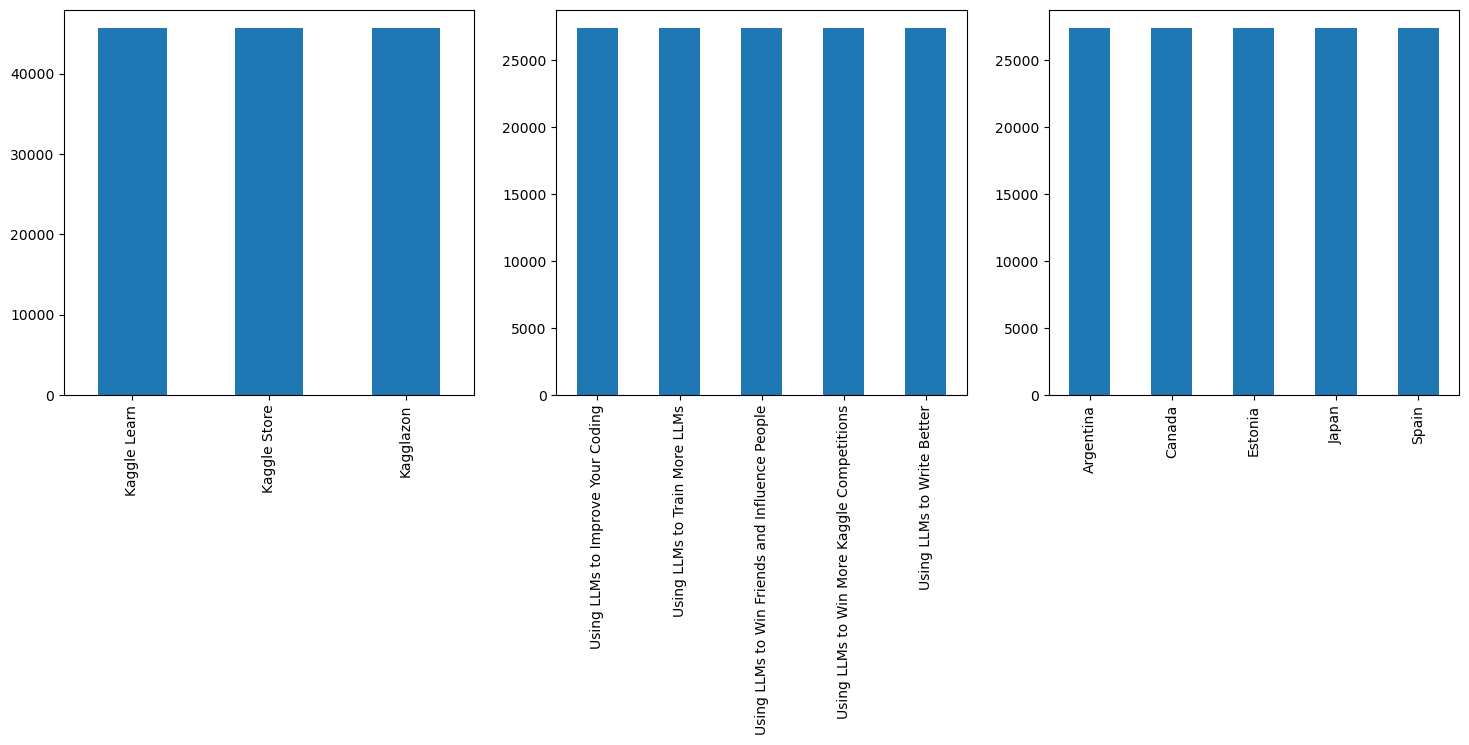

In [181]:
print(data['store'].value_counts())
fig,ax = plt.subplots(1,3, figsize=(18,5))
data['store'].value_counts().plot(kind='bar', ax=ax[0])
data['product'].value_counts().plot(kind='bar', ax=ax[1])
data['country'].value_counts().plot(kind='bar', ax=ax[2])

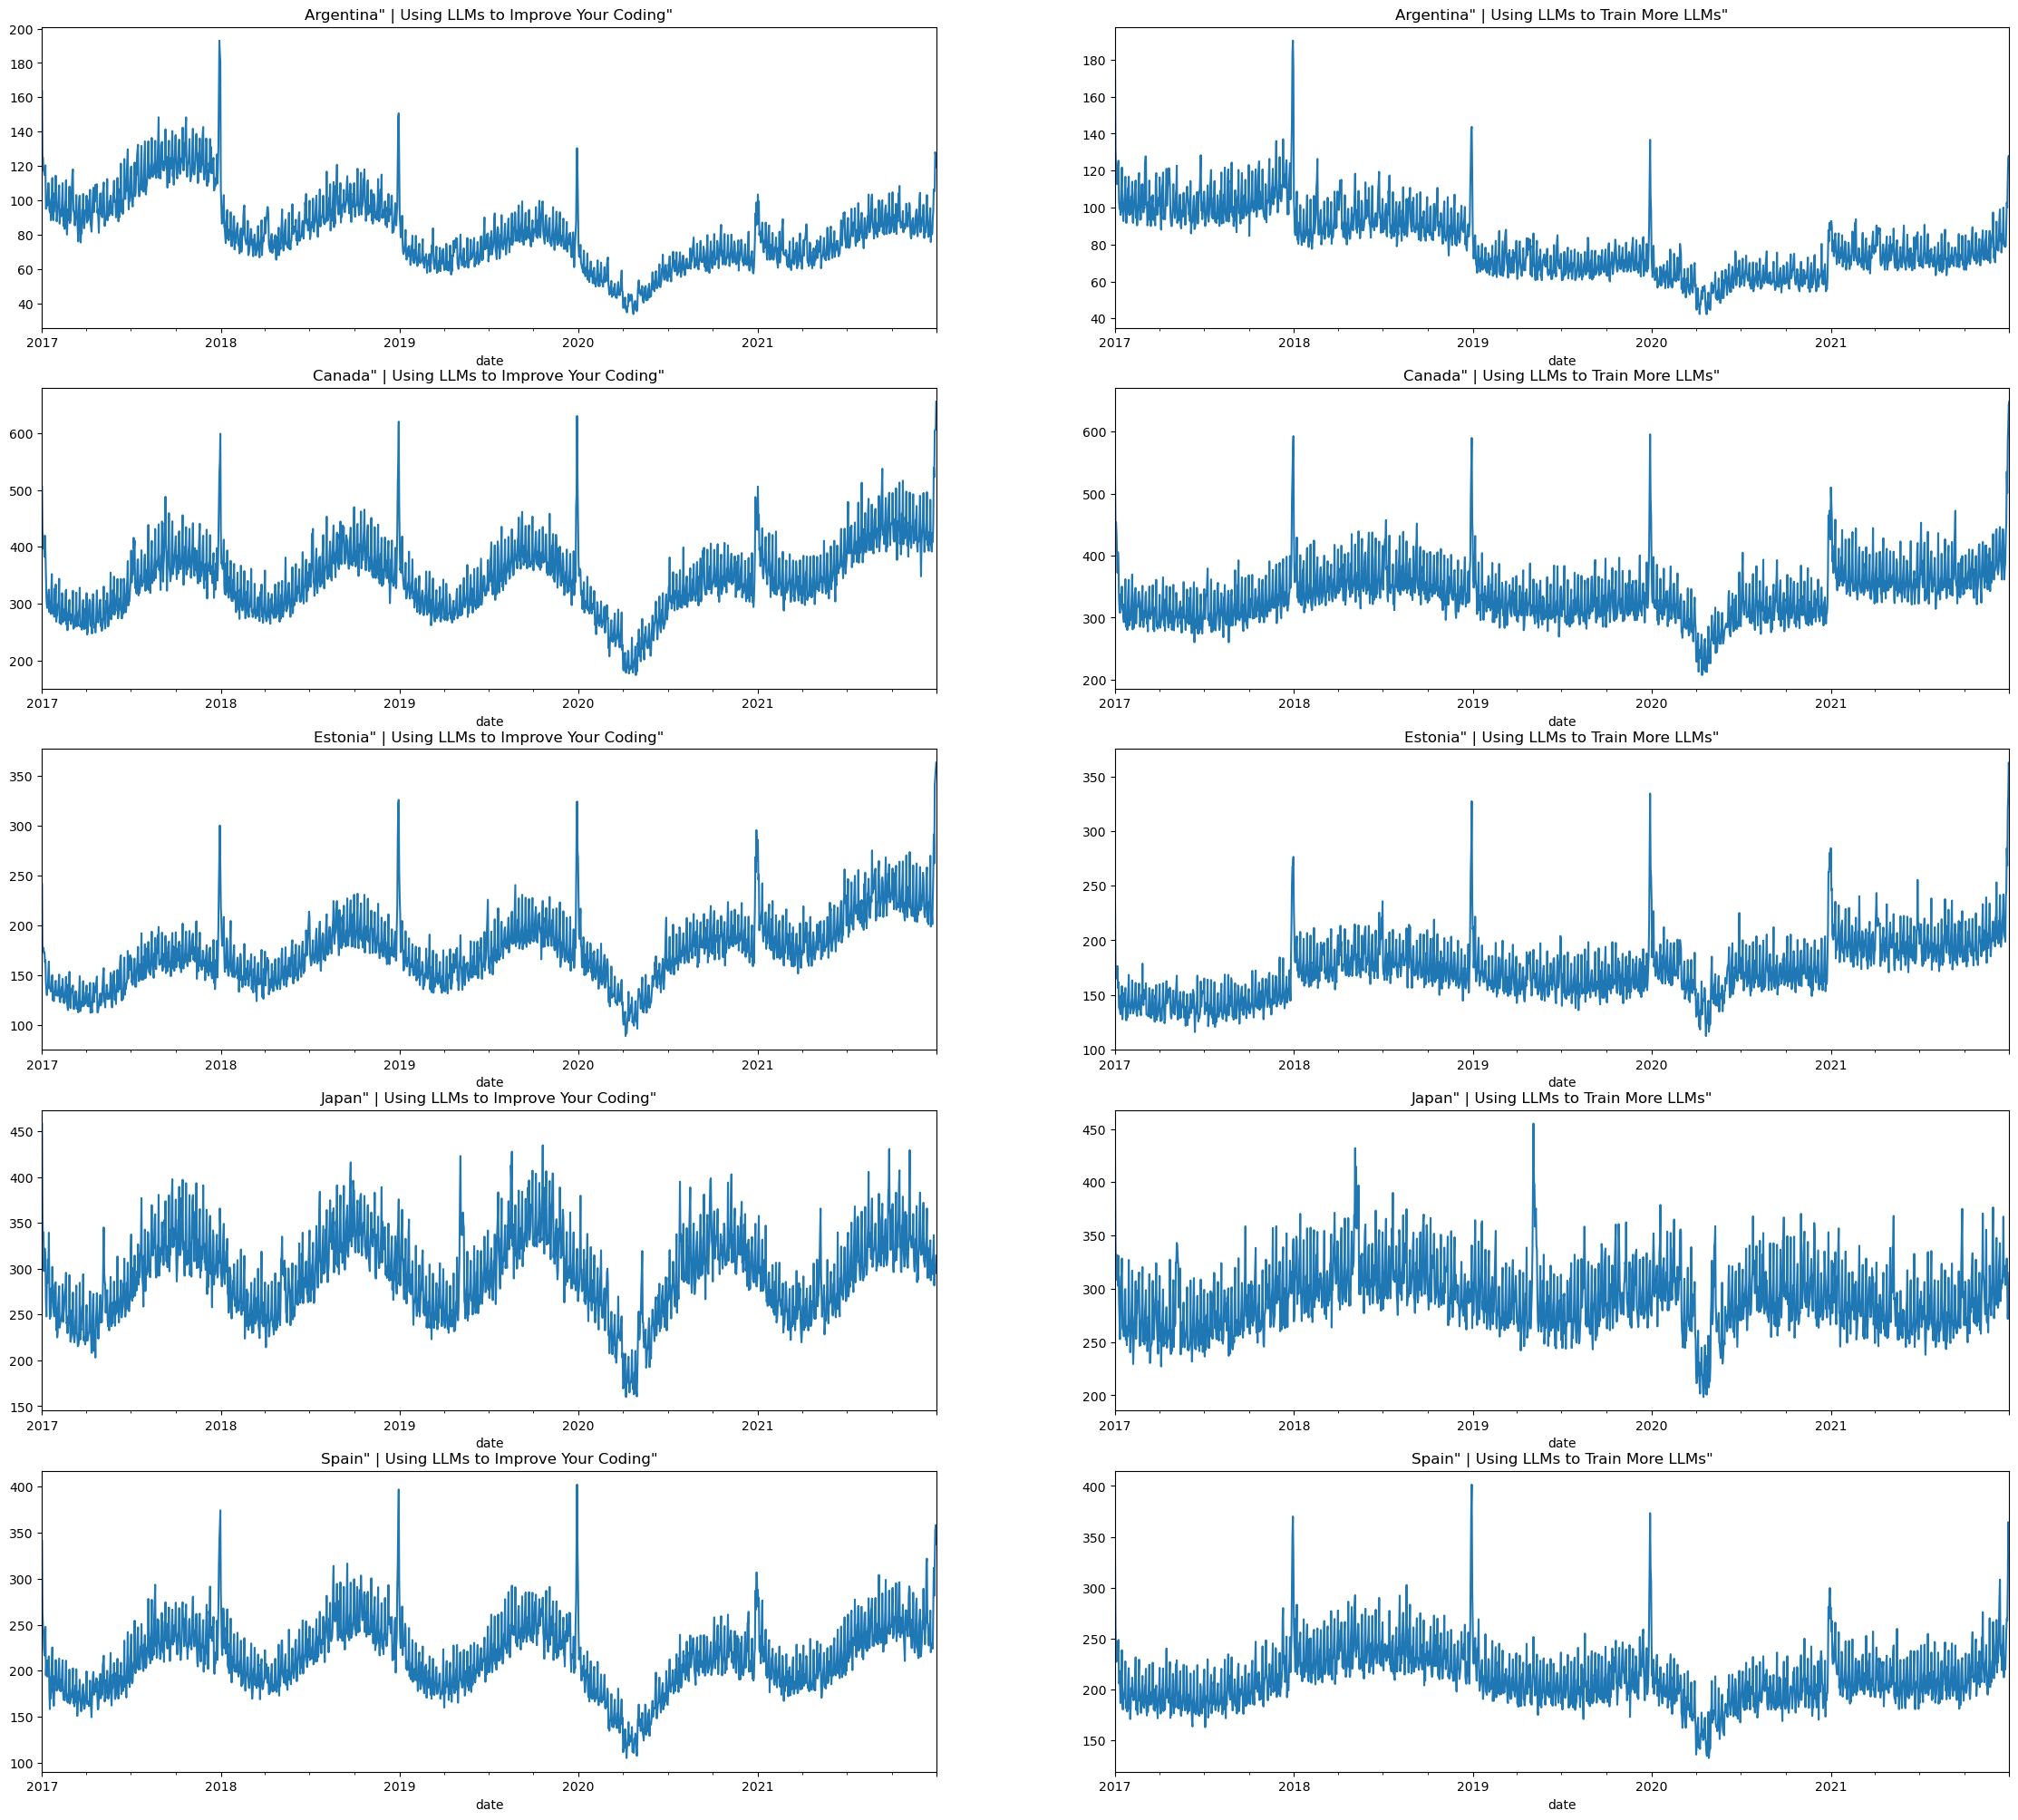

In [182]:
fig,ax = plt.subplots(len(countries),2, figsize=(28,25))
i=0
for c in countries:
    j=0
    for p in products[:2]:
        df = data[(data['country'] == c) & (data['product'] == p)][['date','num_sold']].groupby('date').mean()
        df['num_sold'].plot(ax=ax[i,j])
        ax[i,j].set_title(f'{c}" | {p}"')
        #sns.lineplot(x=df['date'],y=df['num_sold'] ,linewidth=1,ci=None,ax=ax)
        j=j+1
    i=i+1
            
plt.show()

# In above graph, we can clearly observe yearly pattern in selling. To be clear, i have again plotted few products below from different stores. Note that year 2020 has little different selling behaviour. it might be because of covid situation

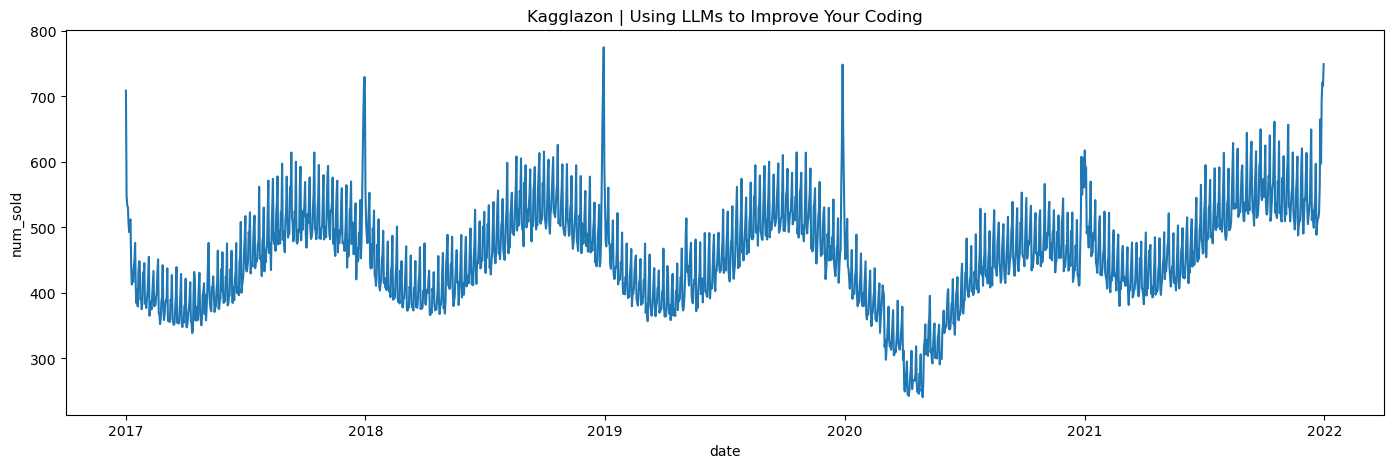

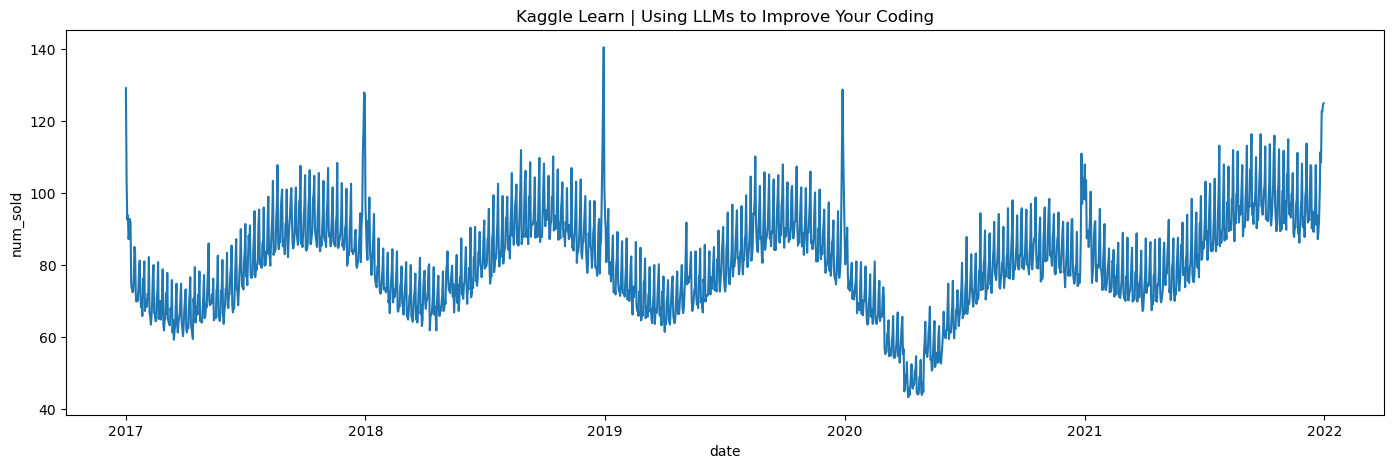

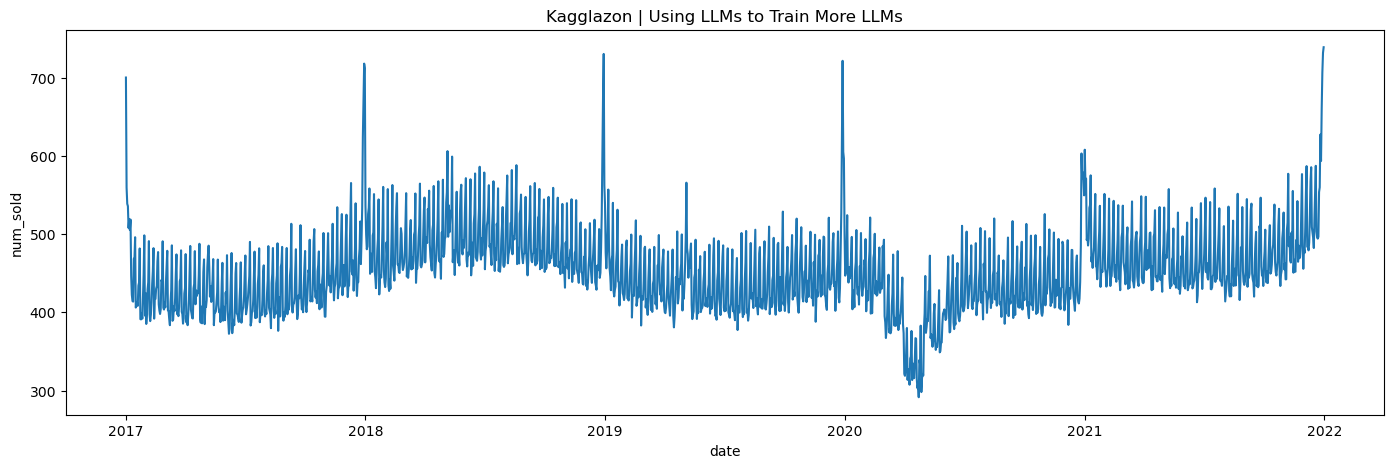

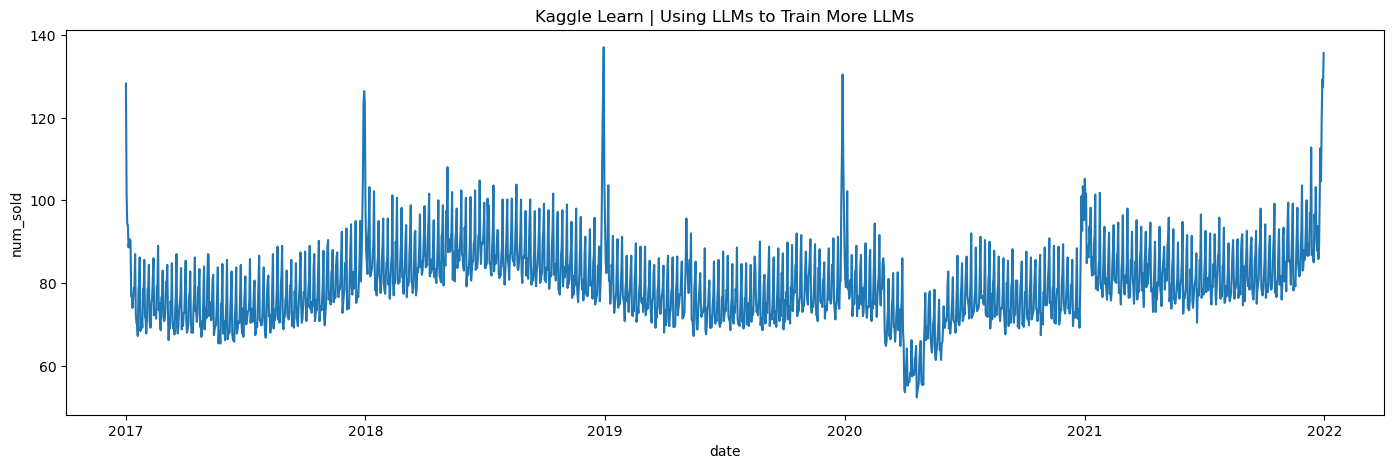

In [183]:
col = ['date','product','store','country','num_sold']
for product in products[:2]:
    for store in stores[:2]:
        plt.figure(figsize=(17,5))
        df = data[data['product'] == product][data['store'] == store][col].groupby('date').mean()
        sns.lineplot(x='date',y='num_sold',ci=None, data=df)
        plt.title(f"{store} | {product}")
        plt.show()

# As we saw in above grpah that yesr 2020 has little different selling bahaviour. Lets analyze when did that start.

<Axes: xlabel='date'>

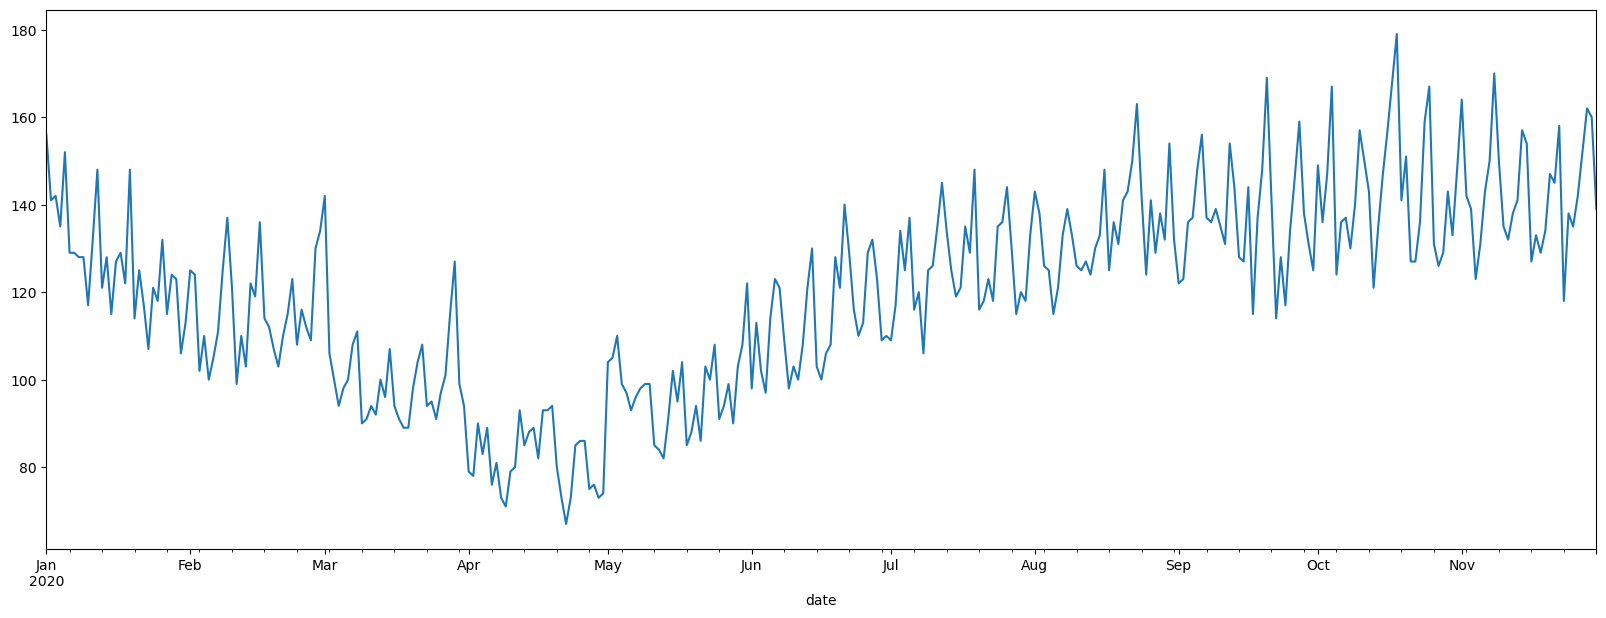

In [233]:
diff = data[(data['country'] == 'Argentina') & (data['store'] == 'Kagglazon') & (data['product'] == 'Using LLMs to Improve Your Coding')]
diff['date'] = pd.to_datetime(diff['date'])
start = pd.to_datetime('2020-01-01')
end = pd.to_datetime('2020-12-01')
_,ax = plt.subplots(figsize=(20,7))
diff[(diff['date']>=start) & (diff['date']< end)].set_index('date')['num_sold'].plot(kind='line', ax=ax)

# Above graph shows pattern changed in between april and may

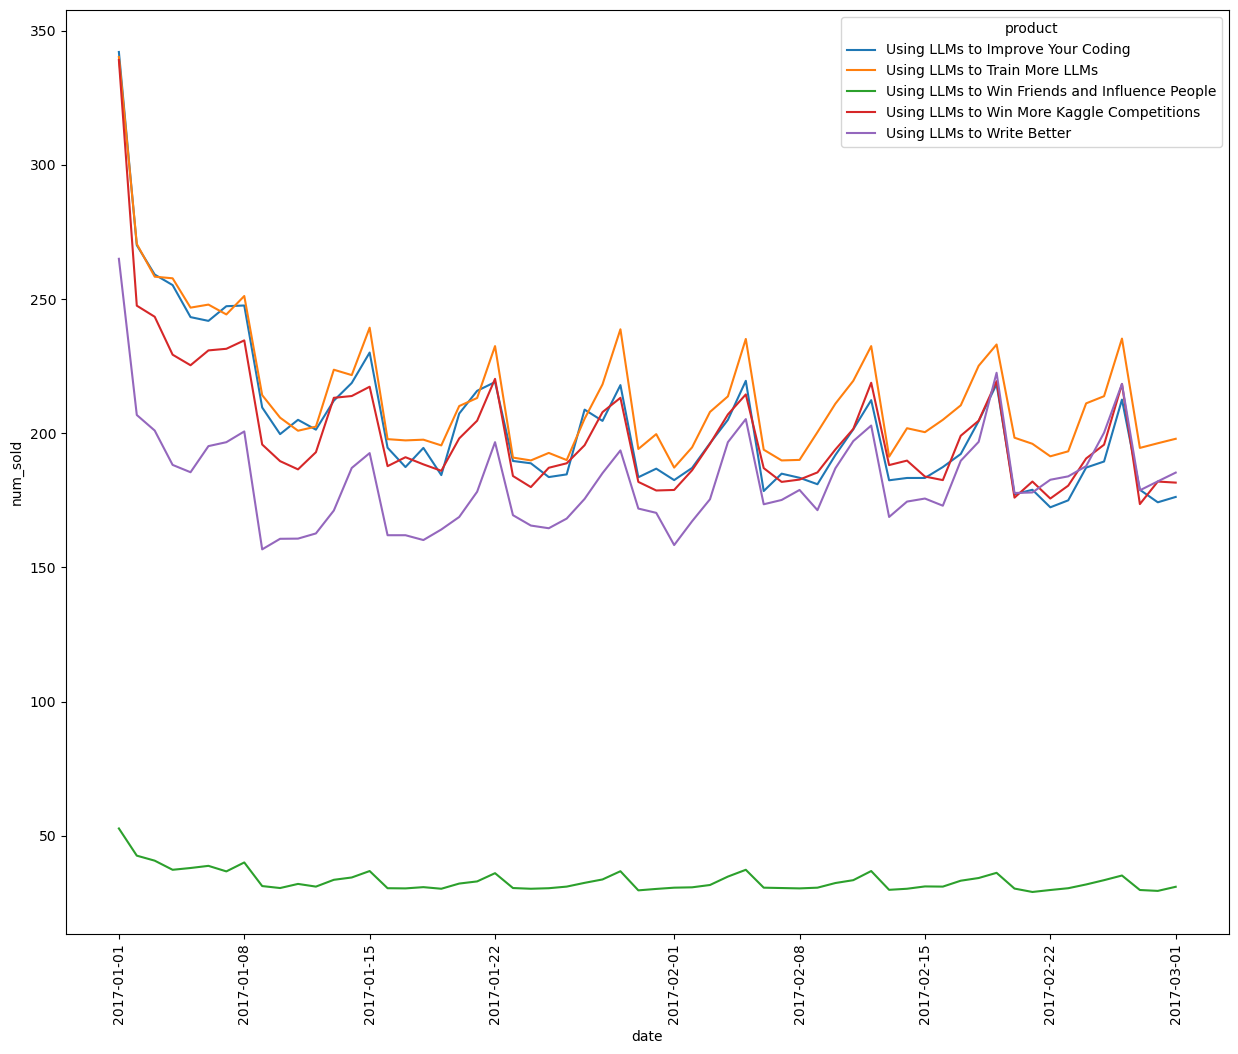

In [184]:
df = data.copy()
    
start = '2017-01-01'
end = '2017-03-01'

fig,ax = plt.subplots(figsize=(15,12))
temp_dff = df[['num_sold','date','product']][(df['date'] >= start) & (df['date'] <= end)].groupby(['date','product']).mean().reset_index()
#print(temp_dff)
sns.lineplot(x='date', y='num_sold', hue='product', data=temp_dff, ci=None)
plt.xticks(rotation=90)
plt.show()

# DATA Also shows weekly pattern. lets verify the same using PACF plot for a perticular product

# But before applying PACF, we will have to make data stationary if it is not already. We will use adfuller hypothesis testing to check if the data is stationary.

# with adfuller hypothesis test:
# H0:  Data is not stationary
# H1:  Data is stationary

In [185]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
int_data = data[(data['country']=='Argentina') & (data['store']=='Kaggle Learn') &  (data['product']=='Using LLMs to Improve Your Coding')]['num_sold']

adfuller(int_data)

(-1.661765270838378,
 0.45091194580391397,
 25,
 1800,
 {'1%': -3.4339881389288407,
  '5%': -2.863147035877915,
  '10%': -2.567625533641975},
 8380.006897141702)

# P-vlues(2nd element) is .45, which means, data is not stationary. Now to make it stationary, we will apply differencing

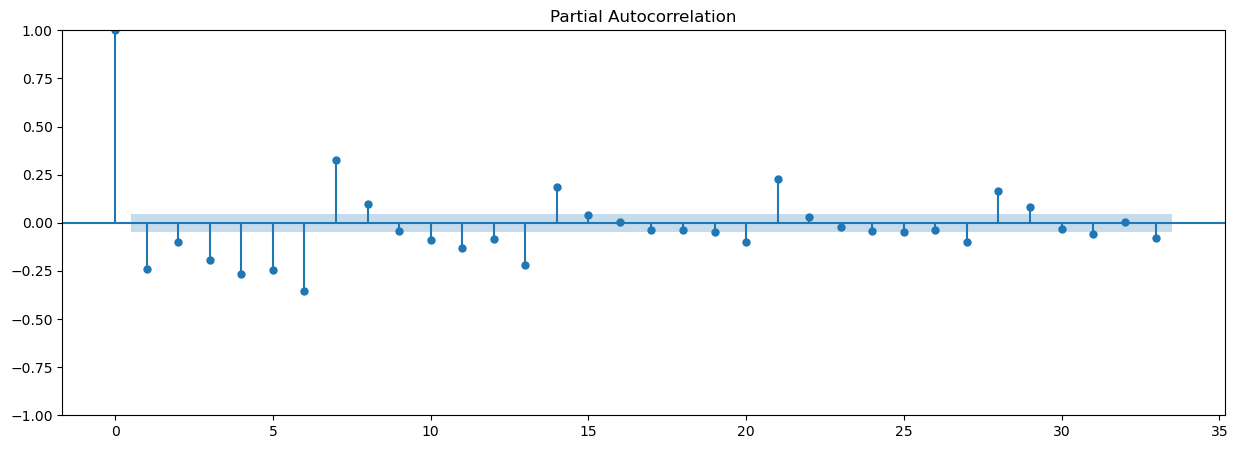

In [187]:
int_data = data[(data['country']=='Argentina') & (data['store']=='Kaggle Learn') &  (data['product']=='Using LLMs to Improve Your Coding')]['num_sold'].diff().dropna()
fig,ax = plt.subplots(figsize=(15,5))
plot_pacf(int_data, ax=ax)
plt.show()

# PACF seems to show that data indeed has weekly pattern

# DATA PREPARATION AND MODEL BUILDING

# Below functions are responsible for creating lag varibales and other feature engineering realted to timeseries

# Also i am creating moving avarage faetures for certain periods with exponential decay. Doing this will give more weightage to most recent selling behaviour

In [2]:
countries = sorted(list(set(data['country'])))
products = sorted(list(set(data['product'])))
stores = sorted(list(set(data['store'])))
alpha  = 0.06
def create_time_series_faetures(df, lag=7):
    if 'date' in df.columns:
        df = df.set_index('date')
    # Calculate the first-order difference of the sales data
    # df['differencing'] = df['num_sold'].diff().shift(1)
    for i in [14,30,90]:
        df['Rolling_Mean_{}'.format(i)] = df['num_sold'].rolling(window=i).apply(lambda x: x.ewm(alpha=alpha).mean().iloc[-1]).shift(1)
        df['Rolling_Std_{}'.format(i)] = df['num_sold'].rolling(window=i).apply(lambda x: x.ewm(alpha=alpha).std().iloc[-1]).shift(1)
#         df['Rolling_Min_{}'.format(i)] = df['num_sold'].rolling(window=i).min().shift(1)
#         df['Rolling_Max_{}'.format(i)] = df['num_sold'].rolling(window=i).max().shift(1)
                                                                                                                                                                         
#         df['Rolling_Quantile_25_{}'.format(i)] = df['num_sold'].rolling(window=i).quantile(0.25).shift(1)
#         df['Rolling_Quantile_50_{}'.format(i)] = df['num_sold'].rolling(window=i).quantile(0.5).shift(1)
#         df['Rolling_Quantile_75_{}'.format(i)] = df['num_sold'].rolling(window=i).quantile(0.75).shift(1)
    return df


def create_lags(data, lags):
    for i in range(lags):
        data['lag_{}'.format(i+1)] = data['num_sold'].shift(i+1)    
    return data


def clreate_lags_by_group(data, lags=7):
    cols = list(data.columns)
    for i in range(lags):
        cols.append('lag_{}'.format(i+1))
    final_data = pd.DataFrame()

    for country in countries:
        for product in products:
            for store in stores:
                temp = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]
                lagged_data = create_lags(temp, lags) 
                timeseries_data = create_time_series_faetures(lagged_data, lag=7)
                final_data = pd.concat([final_data,timeseries_data], axis=0)
                
    
    return final_data.reset_index()

# Below function engineer few importent features that can help understanding the data in a better way

In [297]:
alpha = 0.1
def create_month_based_feature(data):
    month_data = pd.DataFrame()
    for country in countries:
        for product in products:
            for store in stores:
                temp = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]
                temp = temp[['country','store','product','month','num_sold']]
                #temp = temp.groupby(['country','store','product','month']).mean().reset_index().rename(columns={'num_sold':'month_avg_sold'})
                #temp = temp.groupby(['country','store','product','month']).agg({'num_sold': ['max', 'min', 'mean', 'std']})
                temp = temp.groupby(['country', 'store', 'product', 'month'])['num_sold'].agg([
                    ('mean', lambda x: x.ewm(alpha=alpha).mean().iloc[-1]),
                    ('std', lambda x: x.ewm(alpha=alpha).std().iloc[-1])
                ])
                predecessor = 'month_'
                temp.columns = [f"{predecessor}_{col}" for col in temp.columns]
                temp = temp.reset_index()
                month_data = pd.concat([month_data,temp], axis=0)
    return month_data

def create_week_based_feature(data):
    week_data = pd.DataFrame()
    for country in countries:
        for product in products:
            for store in stores:
                temp = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]
                temp = temp[['country','store','product','week','num_sold']]
                #temp = temp.groupby(['country','store','product','week']).mean().reset_index().rename(columns={'num_sold':'week_avg_sold'})
                #temp = temp.groupby(['country','store','product','week']).agg({'num_sold': ['max', 'min', 'mean', 'std']})
                temp = temp.groupby(['country', 'store', 'product', 'week'])['num_sold'].agg([
                    ('mean', lambda x: x.ewm(alpha=alpha).mean().iloc[-1]),
                    ('std', lambda x: x.ewm(alpha=alpha).std().iloc[-1])
                ])
                
                predecessor = 'week_'
                temp.columns = [f"{predecessor}_{col}" for col in temp.columns]
                temp = temp.reset_index()
                week_data = pd.concat([week_data,temp], axis=0)
    return week_data

def create_quarter_based_feature(data):
    quarter_data = pd.DataFrame()
    for country in countries:
        for product in products:
            for store in stores:
                temp = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]
                temp = temp[['country','store','product','quarter','num_sold']]
                #temp = temp.groupby(['country','store','product','quarter']).mean().reset_index().rename(columns={'num_sold':'quarter_avg_sold'})
                #temp = temp.groupby(['country','store','product','quarter']).agg({'num_sold': ['max', 'min', 'mean', 'std']})
                temp = temp.groupby(['country', 'store', 'product', 'quarter'])['num_sold'].agg([
                    ('mean', lambda x: x.ewm(alpha=alpha).mean().iloc[-1]),
                    ('std', lambda x: x.ewm(alpha=alpha).std().iloc[-1])
                ])
                predecessor = 'quarter_'
                temp.columns = [f"{predecessor}_{col}" for col in temp.columns]
                temp = temp.reset_index()
                quarter_data = pd.concat([quarter_data,temp], axis=0)
    return quarter_data



data = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
data['date'] = pd.to_datetime(data['date'])

data2= data.copy()
data2['year'] = data2['date'].dt.year
data2['month'] = data2['date'].dt.month
data2['quarter'] = data2['date'].dt.quarter
data2['week'] = data2['date'].dt.dayofweek

month_data = create_month_based_feature(data2)
week_data = create_week_based_feature(data2)
quarter_data = create_quarter_based_feature(data2)

In [3]:
def add_covid_flag(date):
    threshold = pd.to_datetime("2020-04-09")
    if date > threshold:
        return 1
    else:
        return 0
    

def prepare_data(data, train_flag=False, lag_flag=False):
    if 'date' in data.columns:
        data['date'] = pd.to_datetime(data['date'])

    df = data.copy()
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['week'] = df['date'].dt.dayofweek
    #df['dayofyear'] = df['date'].dt.dayofyear
    df['day'] = df['date'].dt.day
    #df['covid_flag'] = df['date'].apply(add_covid_flag)
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofweek / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofweek / 7)
    
#     df = df.merge(month_data, on=['country','store','product','month'])
#     df = df.merge(week_data, on=['country','store','product','week'])
#     df = df.merge(quarter_data, on=['country','store','product','quarter'])
    
    if train_flag:
        df = df.drop(['id'], axis=1)
        #df = drop_2020(df)
        country_label_encoder.fit(df['country'])
        store_label_encoder.fit(df['store'])
        product_label_encoder.fit(df['product'])
    
    df['country'] = country_label_encoder.transform(df['country'])
    df['store'] = store_label_encoder.transform(df['store'])
    df['product'] = product_label_encoder.transform(df['product'])
    
    df = df.sort_values(by='date')
    if 'date' in df.columns:
        df = df.set_index('date')
        
    return df.dropna()

# Below is time based train test split

In [4]:
def train_test_split(int_data, train_split=0.9):
    import datetime
    #train_lim = datetime.datetime.strptime('2020-01-01','%Y-%m-%d')
    train_lim = int(len(int_data)*train_split)
    train = int_data[:train_lim]
    test = int_data[train_lim:]
    
    train_x = train.drop(['num_sold'], axis=1)
    train_y = train['num_sold']
    test_x =  test.drop(['num_sold'], axis=1)
    test_y = test['num_sold']

    return (train_x, train_y, test_x, test_y)

# Preprocess Data

In [191]:
df = prepare_data(data, train_flag=True)

In [192]:
weeks = sorted(list(set(df['week'])))
months = sorted(list(set(df['month'])))
quarters = sorted(list(set(df['quarter'])))
years = sorted(list(set(df['year'])))

# Sales by each year and month is shown below

<Axes: >

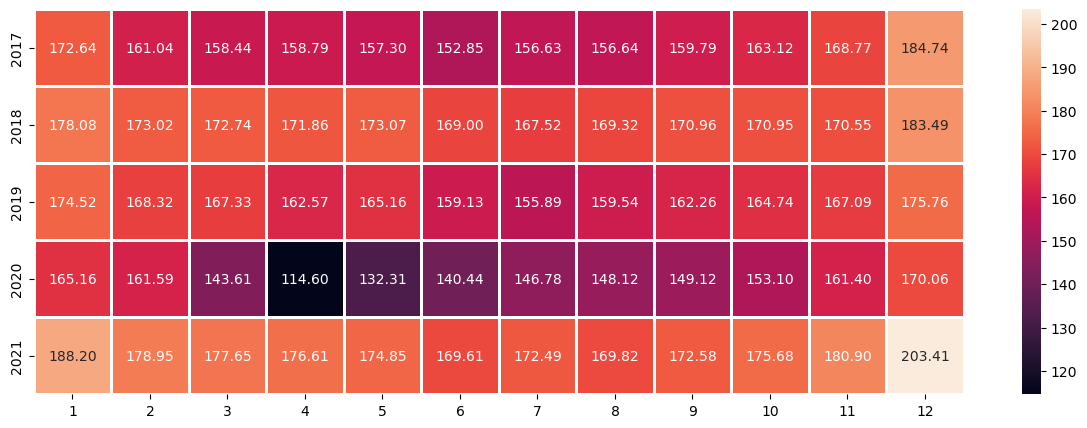

In [193]:
col = 'year'
res = pd.DataFrame(df[[col,'month','num_sold']].groupby([col,'month']).mean().values.reshape(len(years),len(months)), columns=months).set_index([years])
plt.figure(figsize=(15,5))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# Product sales on different week-day

Text(0.5, 1.0, 'product sold by week')

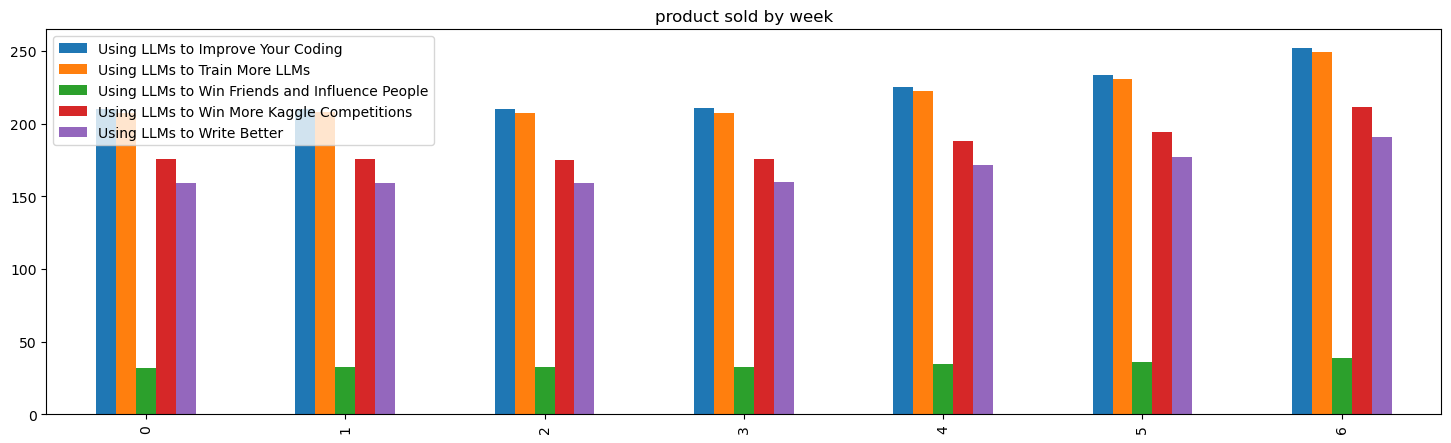

In [194]:
col = 'week'
res = pd.DataFrame(df[[col,'product','num_sold']].groupby([col,'product']).mean().values.reshape(len(weeks),len(products)), columns=products).set_index([weeks])
fig, ax = plt.subplots(figsize=(18, 5))
res.plot(kind='bar', ax=ax)
plt.title(f"product sold by {col}")

<Axes: >

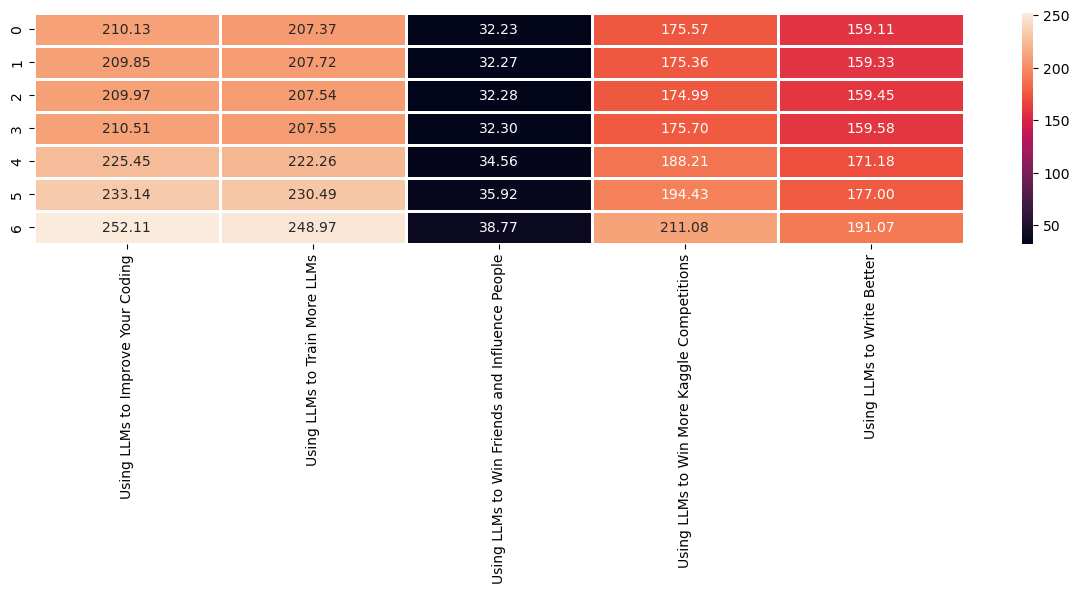

In [195]:
plt.figure(figsize=(15,3))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# Above graph shows that weekday 6 has the highest sales

# product sales in each month is shown below

Text(0.5, 1.0, 'product sold by month')

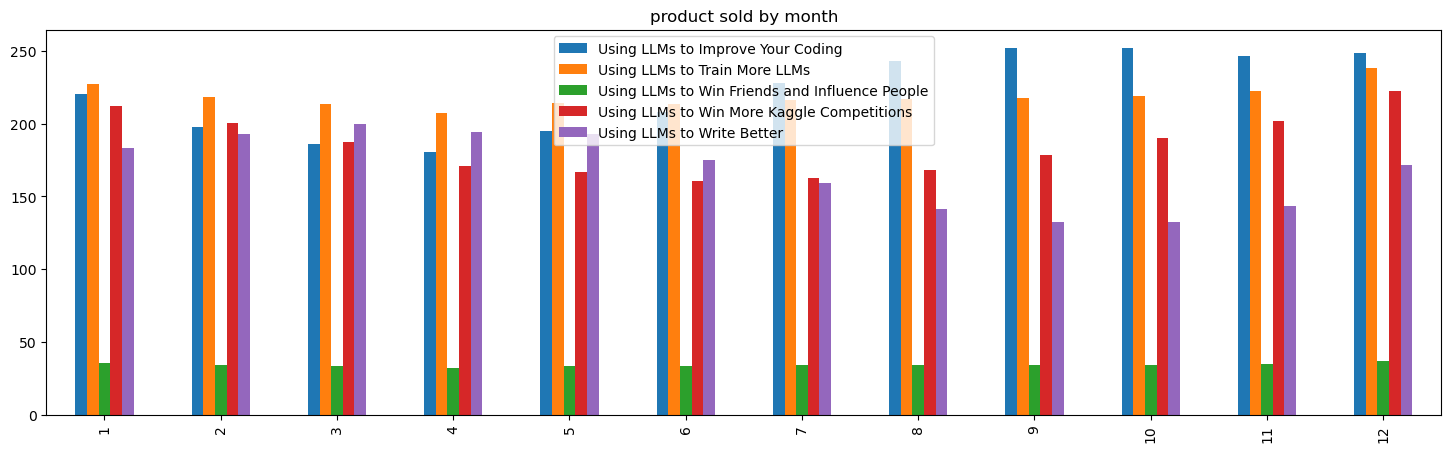

In [196]:
col = 'month'
res = pd.DataFrame(df[[col,'product','num_sold']].groupby([col,'product']).mean().values.reshape(len(months),len(products)), columns=products).set_index([months])
fig, ax = plt.subplots(figsize=(18, 5))
res.plot(kind='bar', ax=ax)
plt.title(f"product sold by {col}")

<Axes: >

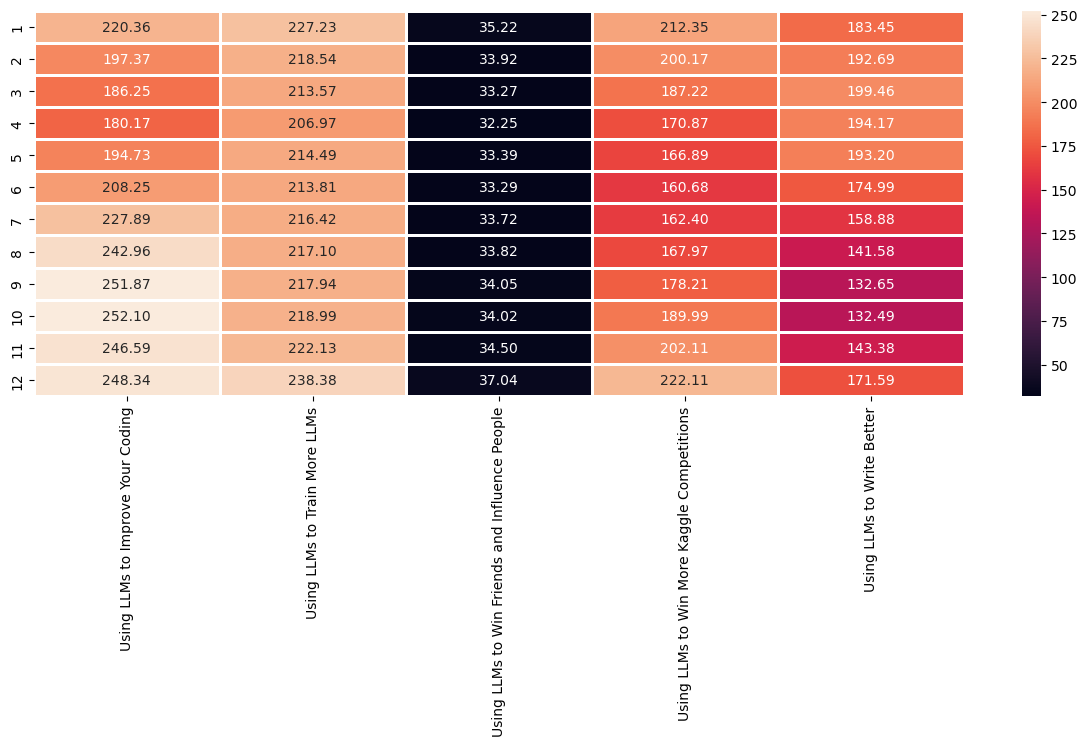

In [197]:
plt.figure(figsize=(15,5))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# Product sales by quarter

Text(0.5, 1.0, 'product sold by quarter')

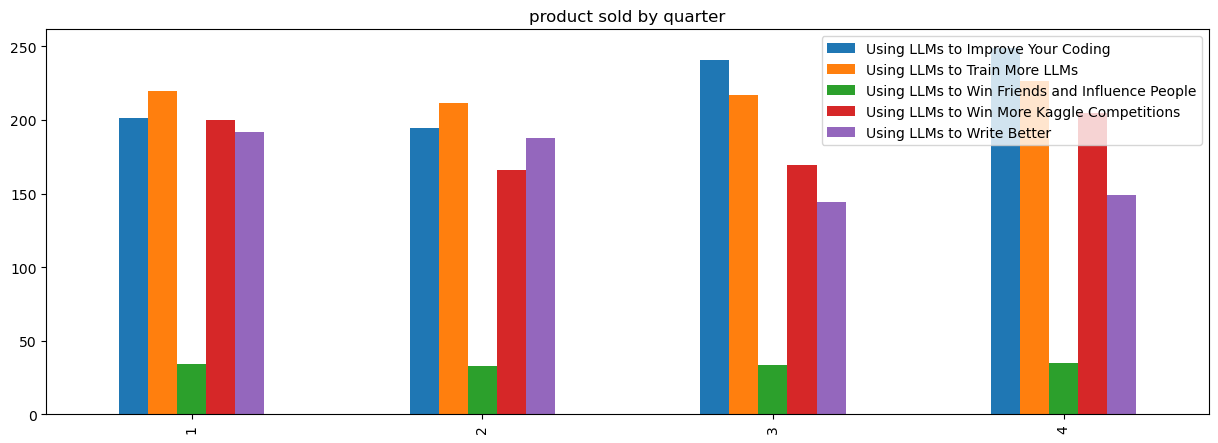

In [198]:
col = 'quarter'
res = pd.DataFrame(df[[col,'product','num_sold']].groupby([col,'product']).mean().values.reshape(len(quarters),len(products)), columns=products).set_index([quarters])
fig, ax = plt.subplots(figsize=(15, 5))
res.plot(kind='bar', ax=ax)
plt.title(f"product sold by {col}")

<Axes: >

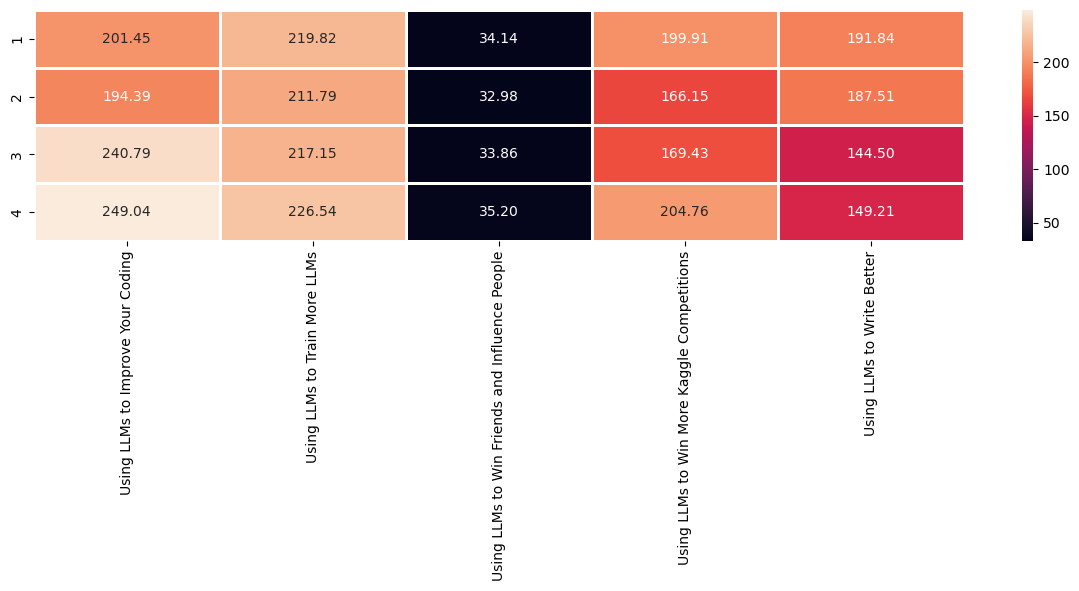

In [199]:
plt.figure(figsize=(15,3))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# Product sales by Year

Text(0.5, 1.0, 'product sold by year')

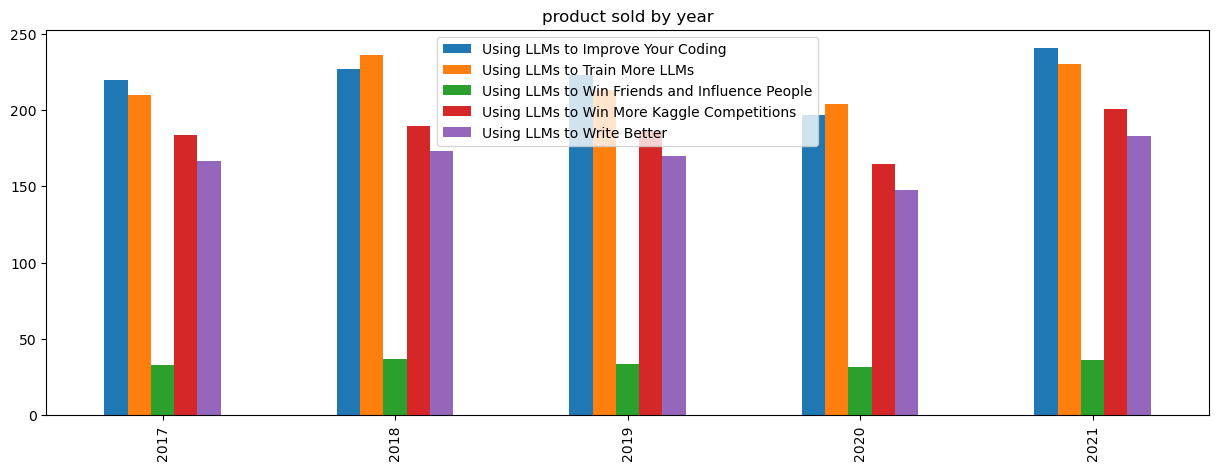

In [200]:
col = 'year'
res = pd.DataFrame(df[[col,'product','num_sold']].groupby([col,'product']).mean().values.reshape(len(years),len(products)), columns=products).set_index([years])
fig, ax = plt.subplots(figsize=(15, 5))
res.plot(kind='bar', ax=ax)
plt.title(f"product sold by {col}")

<Axes: >

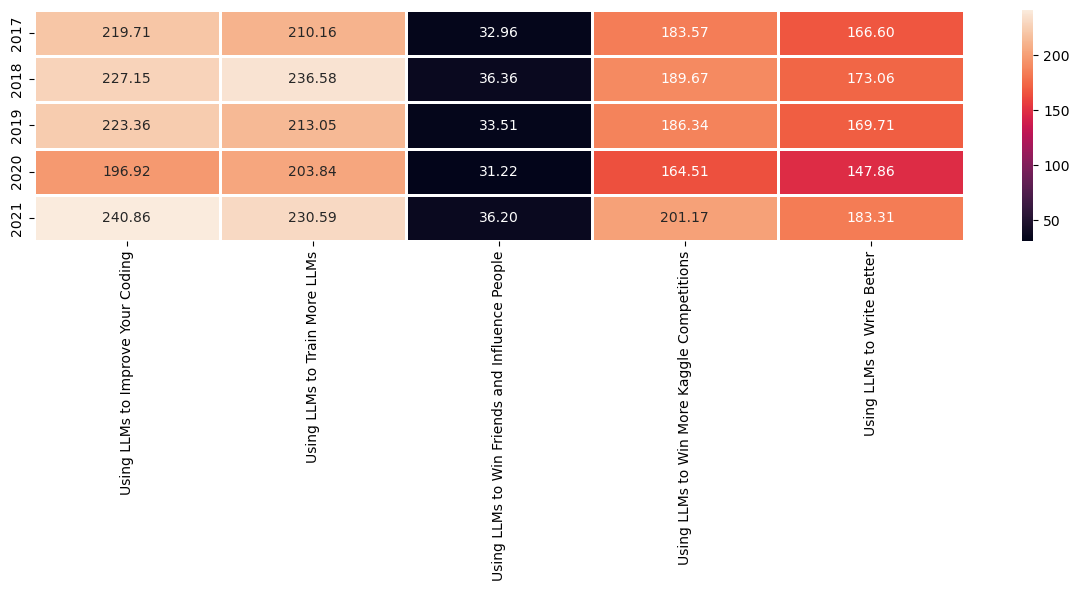

In [201]:
plt.figure(figsize=(15,3))
sns.heatmap(res, annot=True, fmt='.2f', linewidth=1)

# Get TRAIN TEST SPLIT

In [112]:
df = prepare_data(data, train_flag=True)
train_x, train_y, test_x, test_y = train_test_split(df)
print(train_x.shape)
print(test_x.shape)

(123255, 10)
(13695, 10)


In [113]:
test_x.head()

country  store  product  year  month  quarter  week  day  \
date                                                                   
2021-07-02        4      1        2  2021      7        3     4    2   
2021-07-02        4      1        1  2021      7        3     4    2   
2021-07-02        4      1        0  2021      7        3     4    2   
2021-07-02        3      0        4  2021      7        3     4    2   
2021-07-02        4      2        1  2021      7        3     4    2   

            DayOfWeek_sin  DayOfWeek_cos  
date                                      
2021-07-02      -0.433884      -0.900969  
2021-07-02      -0.433884      -0.900969  
2021-07-02      -0.433884      -0.900969  
2021-07-02      -0.433884      -0.900969  
2021-07-02      -0.433884      -0.900969

# Try models with engineered features only(month, week, year etc), without any lag variables

In [114]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Create the XGBRegressor model
xgb_model = XGBRegressor()

# Fit the model to the data
xgb_model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [115]:
y_pred_xg = xgb_model.predict(test_x)
mse_value = mean_squared_error(y_pred_xg, test_y)
res = pd.DataFrame(zip(map(int,y_pred_xg),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 581.3412885652633


predicted  truth       date
0         14     12 2021-07-02
1         79     75 2021-07-02
2         77     75 2021-07-02
3        500    525 2021-07-02
4        120    120 2021-07-02
5         90     94 2021-07-02
6        109     99 2021-07-02
7         13     18 2021-07-02
8        142    147 2021-07-02
9        133    132 2021-07-02

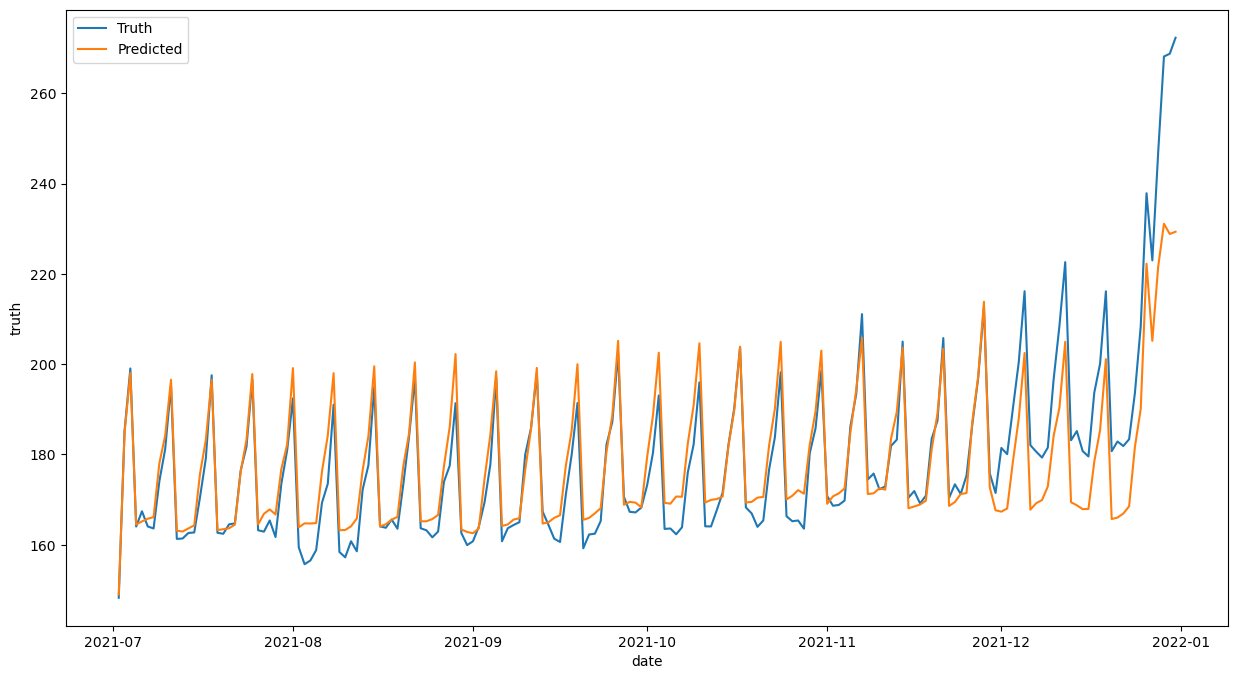

In [116]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

In [117]:
from catboost import CatBoostRegressor
# Create the XGBRegressor model
cat_model = CatBoostRegressor(silent=True,depth=5)

# Fit the model to the data
cat_model.fit(train_x, train_y)

In [118]:
y_pred_cat = cat_model.predict(test_x)
mse_value = mean_squared_error(y_pred_cat, test_y)
res = pd.DataFrame(zip(map(int,y_pred_cat),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 580.775193473065


predicted  truth       date
0          9     12 2021-07-02
1         76     75 2021-07-02
2         80     75 2021-07-02
3        482    525 2021-07-02
4        120    120 2021-07-02
5         88     94 2021-07-02
6        105     99 2021-07-02
7         18     18 2021-07-02
8        154    147 2021-07-02
9        132    132 2021-07-02

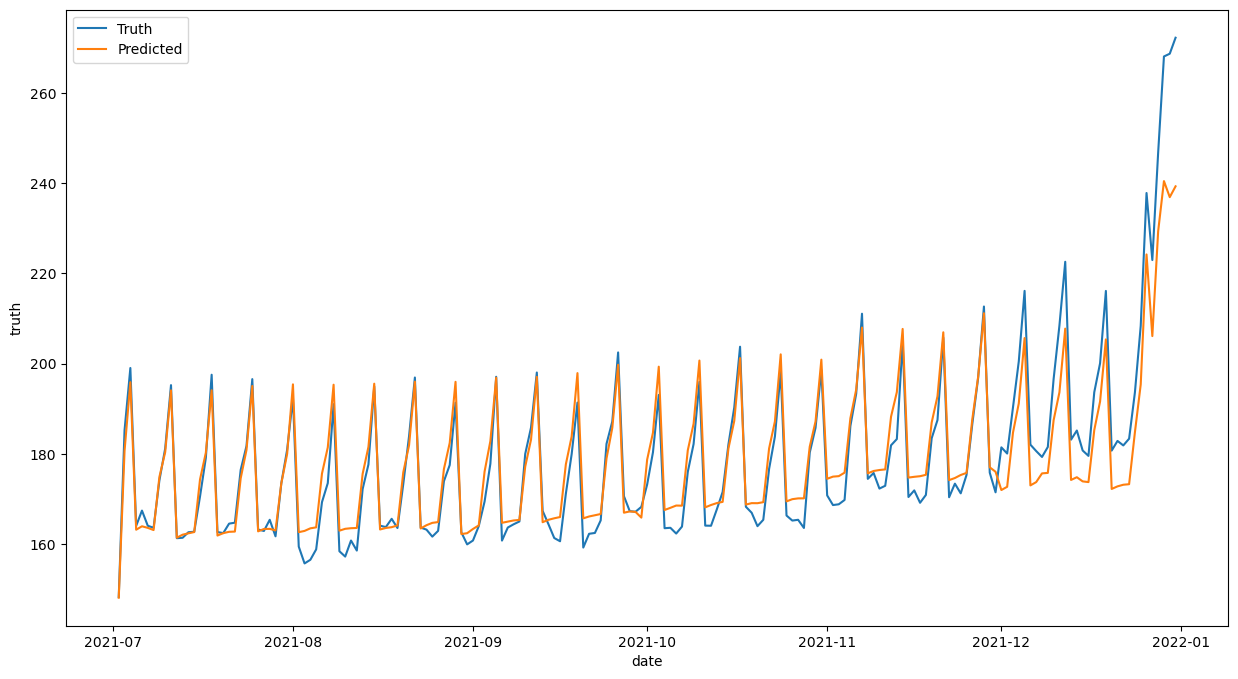

In [119]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

In [120]:
xg_cat_pred = (y_pred_xg + y_pred_cat)/2
res = pd.DataFrame(zip(map(int,xg_cat_pred),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(mean_squared_error(xg_cat_pred, test_y))
res

546.3277431893854


predicted  truth       date
0             11     12 2021-07-02
1             78     75 2021-07-02
2             79     75 2021-07-02
3            491    525 2021-07-02
4            120    120 2021-07-02
...          ...    ...        ...
13690        271    360 2021-12-31
13691        283    383 2021-12-31
13692        161    178 2021-12-31
13693       1004   1333 2021-12-31
13694        500    539 2021-12-31

[13695 rows x 3 columns]

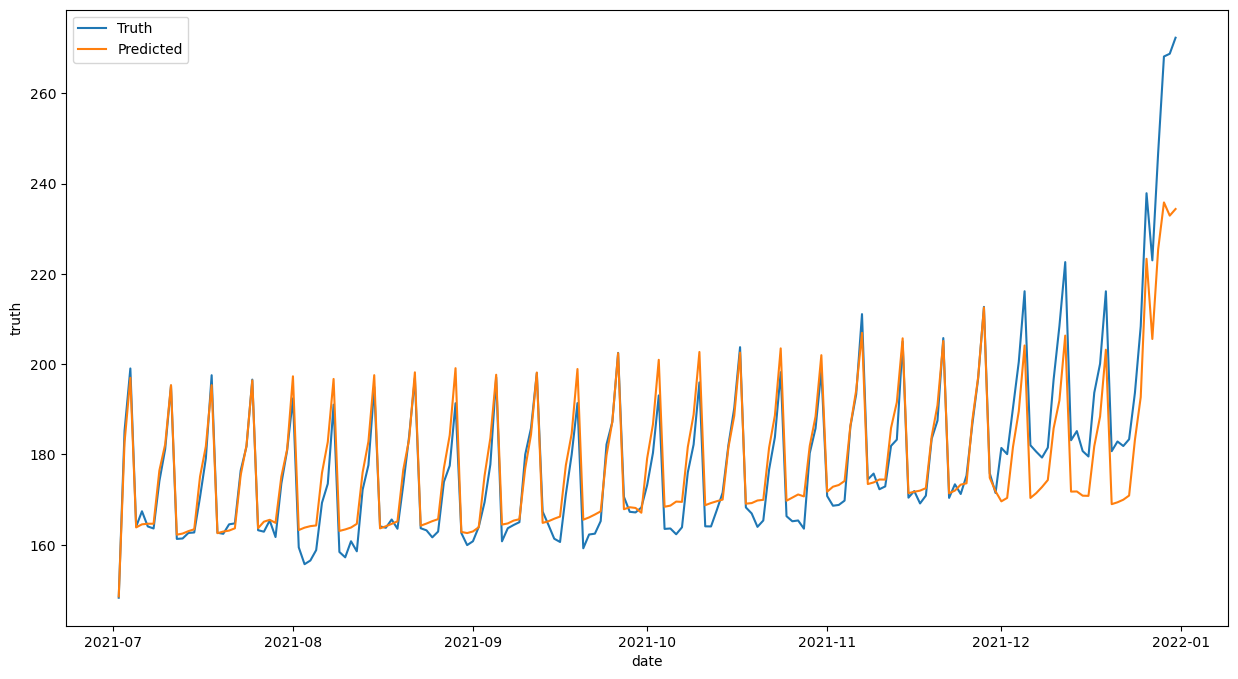

In [121]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

In [ ]:
#help(RandomForestRegressor)

In [124]:
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=15)
random_forest_model.fit(train_x, train_y)

RandomForestRegressor(max_depth=15)

In [125]:
y_pred = random_forest_model.predict(test_x)
mse_value = mean_squared_error(y_pred, test_y)
res = pd.DataFrame(zip(map(int,y_pred),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 1688.249508260155


predicted  truth       date
0         12     12 2021-07-02
1         76     75 2021-07-02
2         76     75 2021-07-02
3        451    525 2021-07-02
4        123    120 2021-07-02
5         87     94 2021-07-02
6        106     99 2021-07-02
7         18     18 2021-07-02
8        122    147 2021-07-02
9        130    132 2021-07-02

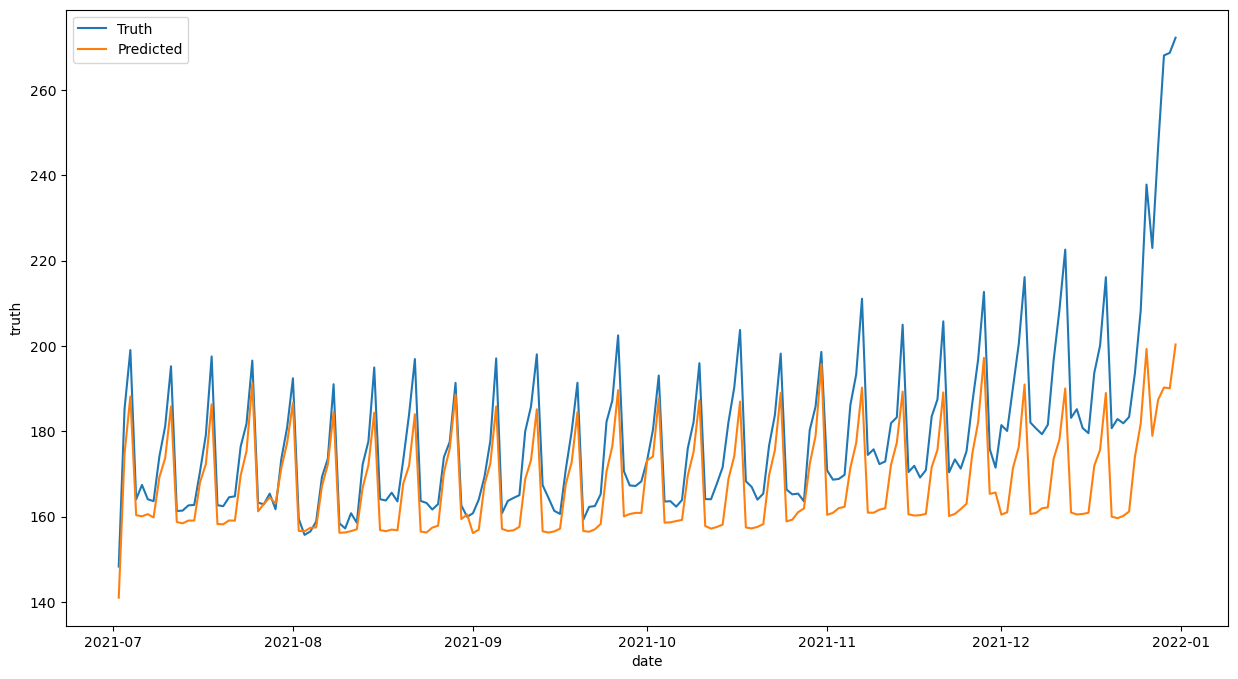

In [126]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

In [122]:
from sklearn.linear_model import LinearRegression, Ridge
linear_model = LinearRegression()
linear_model.fit(train_x, train_y)
y_pred = linear_model.predict(test_x)
mse_value = mean_squared_error(y_pred, test_y)
res = pd.DataFrame(zip(map(int,y_pred),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 27846.33585833422


predicted  truth       date
0        193     12 2021-07-02
1        206     75 2021-07-02
2        219     75 2021-07-02
3        275    525 2021-07-02
4         82    120 2021-07-02
5         24     94 2021-07-02
6        189     99 2021-07-02
7         37     18 2021-07-02
8        170    147 2021-07-02
9        226    132 2021-07-02

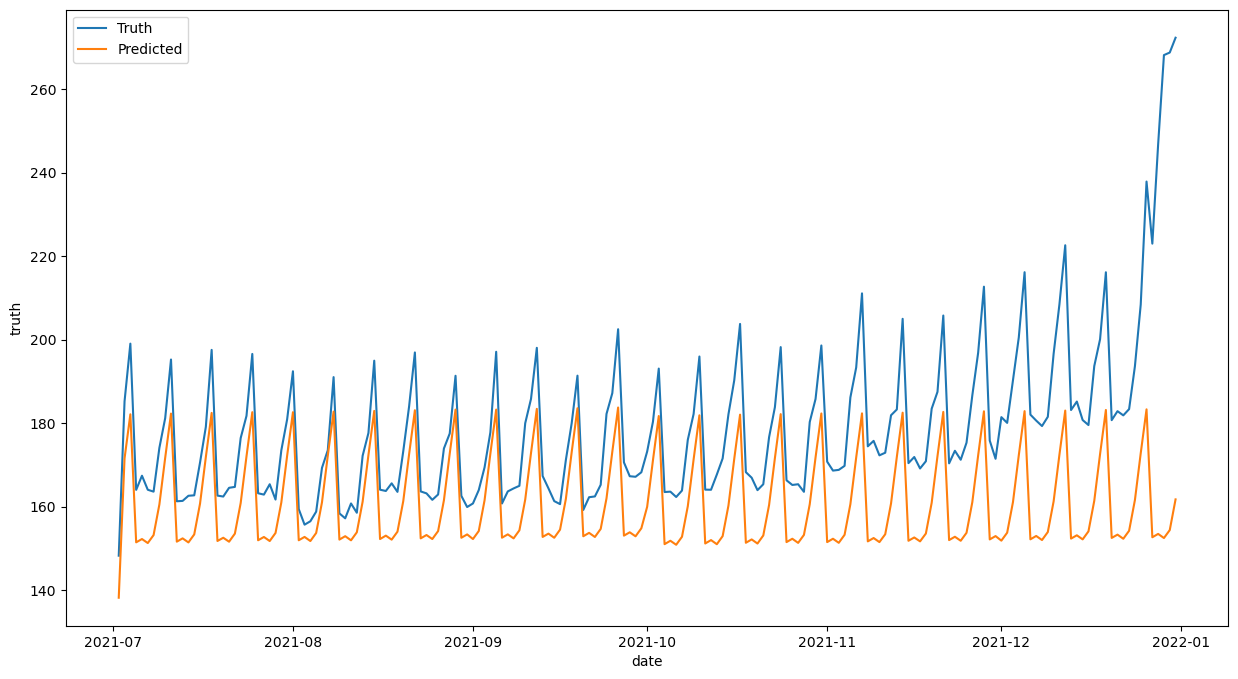

In [123]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

# MODELS WITH ONE WEEK LAG

In [27]:
no_lags = 7

df = clreate_lags_by_group(data, lags=no_lags)
df = prepare_data(df, train_flag=True)
train_x, train_y, test_x, test_y = train_test_split(df)

In [28]:
train_x.head()

country  store  product  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
date                                                                            
2017-04-01        1      0        1  576.0  598.0  573.0  610.0  601.0  757.0   
2017-04-01        1      1        0  109.0  103.0   86.0   99.0  105.0  116.0   
2017-04-01        3      0        3  502.0  468.0  489.0  535.0  552.0  591.0   
2017-04-01        1      0        4  590.0  610.0  558.0  526.0  624.0  681.0   
2017-04-01        0      1        1   36.0   40.0   35.0   39.0   35.0   41.0   

            lag_7  ...  Rolling_Quantile_25_90  Rolling_Quantile_50_90  \
date               ...                                                   
2017-04-01  661.0  ...                  610.75                   651.5   
2017-04-01  111.0  ...                   99.00                   106.0   
2017-04-01  571.0  ...                  488.25                   533.5   
2017-04-01  665.0  ...                  544.25                   581.0   
2017-04-01   41.0  ...                   35.00                    36.0   

            Rolling_Quantile_75_90  year  month  quarter  week  day  \
date                                                                  
2017-04-01                  708.00  2017      4        2     5    1   
2017-04-01                  114.75  2017      4        2     5    1   
2017-04-01                  578.25  2017      4        2     5    1   
2017-04-01                  623.00  2017      4        2     5    1   
2017-04-01                   40.75  2017      4        2     5    1   

            DayOfWeek_sin  DayOfWeek_cos  
date                                      
2017-04-01      -0.974928      -0.222521  
2017-04-01      -0.974928      -0.222521  
2017-04-01      -0.974928      -0.222521  
2017-04-01      -0.974928      -0.222521  
2017-04-01      -0.974928      -0.222521  

[5 rows x 39 columns]

In [29]:
test_x.head()

country  store  product  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
date                                                                            
2021-07-11        0      0        4  130.0  132.0  120.0  117.0  110.0  107.0   
2021-07-11        0      1        0   31.0   29.0   27.0   26.0   27.0   27.0   
2021-07-11        1      0        3  637.0  574.0  563.0  566.0  615.0  592.0   
2021-07-11        0      1        2    4.0    4.0    3.0    4.0    3.0    3.0   
2021-07-11        0      1        4   21.0   21.0   20.0   20.0   20.0   19.0   

            lag_7  ...  Rolling_Quantile_25_90  Rolling_Quantile_50_90  \
date               ...                                                   
2021-07-11  146.0  ...                   130.0                   139.0   
2021-07-11   32.0  ...                    24.0                    26.0   
2021-07-11  729.0  ...                   560.0                   601.5   
2021-07-11    5.0  ...                     4.0                     4.0   
2021-07-11   23.0  ...                    22.0                    24.0   

            Rolling_Quantile_75_90  year  month  quarter  week  day  \
date                                                                  
2021-07-11                   150.5  2021      7        3     6   11   
2021-07-11                    28.0  2021      7        3     6   11   
2021-07-11                   649.0  2021      7        3     6   11   
2021-07-11                     4.0  2021      7        3     6   11   
2021-07-11                    26.0  2021      7        3     6   11   

            DayOfWeek_sin  DayOfWeek_cos  
date                                      
2021-07-11      -0.781831        0.62349  
2021-07-11      -0.781831        0.62349  
2021-07-11      -0.781831        0.62349  
2021-07-11      -0.781831        0.62349  
2021-07-11      -0.781831        0.62349  

[5 rows x 39 columns]

# XGBoost

In [30]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Create the XGBRegressor model
xgb_model_lagged = XGBRegressor()

# Fit the model to the data
xgb_model_lagged.fit(train_x.values, train_y.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [31]:
y_pred_xg = xgb_model_lagged.predict(test_x)
mse_value = mean_squared_error(y_pred_xg, test_y)
res = pd.DataFrame(zip(map(int,y_pred_xg),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 404.84539854974514


predicted  truth       date
0        139    137 2021-07-11
1         33     35 2021-07-11
2        676    652 2021-07-11
3          5      5 2021-07-11
4         22     23 2021-07-11
5        172    166 2021-07-11
6        135    156 2021-07-11
7        185    185 2021-07-11
8        121    110 2021-07-11
9         95     93 2021-07-11

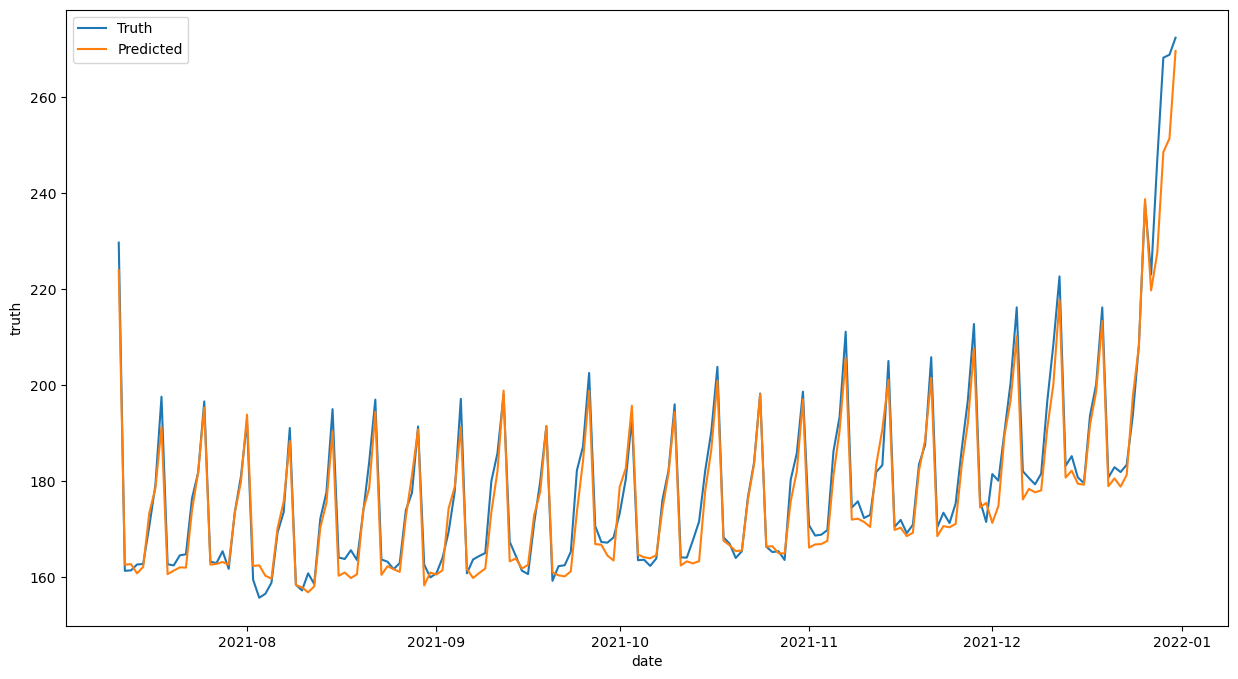

In [32]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

# Parameter tunning XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
xgb_model = XGBRegressor()

# Define hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='r2', cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(train_x, train_y)

# Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [33]:
# Create the XGBRegressor model
xgb_model_lagged = XGBRegressor( max_depth= 5, n_estimators= 200)

# Fit the model to the data
xgb_model_lagged.fit(train_x.values, train_y.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [34]:
y_pred_xg = xgb_model_lagged.predict(test_x)
mse_value = mean_squared_error(y_pred_xg, test_y)
res = pd.DataFrame(zip(map(int,y_pred_xg),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 435.7057255664074


predicted  truth       date
0        135    137 2021-07-11
1         34     35 2021-07-11
2        636    652 2021-07-11
3          4      5 2021-07-11
4         22     23 2021-07-11
5        175    166 2021-07-11
6        137    156 2021-07-11
7        180    185 2021-07-11
8        125    110 2021-07-11
9         96     93 2021-07-11

# Catboost

In [35]:
from catboost import CatBoostRegressor
# Create the XGBRegressor model
cat_model_lagged = CatBoostRegressor(silent=True)

# Fit the model to the data
cat_model_lagged.fit(train_x, train_y)

In [36]:
y_pred_cat = cat_model_lagged.predict(test_x)
mse_value = mean_squared_error(y_pred_cat, test_y)
res = pd.DataFrame(zip(map(int,y_pred_cat),test_y.values), columns=["predicted", "truth"])
res['date'] = test_y.index
print(f"MSE: {mse_value}")
res.head(10)

MSE: 328.4145155739699


predicted  truth       date
0        138    137 2021-07-11
1         32     35 2021-07-11
2        667    652 2021-07-11
3          4      5 2021-07-11
4         23     23 2021-07-11
5        176    166 2021-07-11
6        139    156 2021-07-11
7        184    185 2021-07-11
8        122    110 2021-07-11
9         95     93 2021-07-11

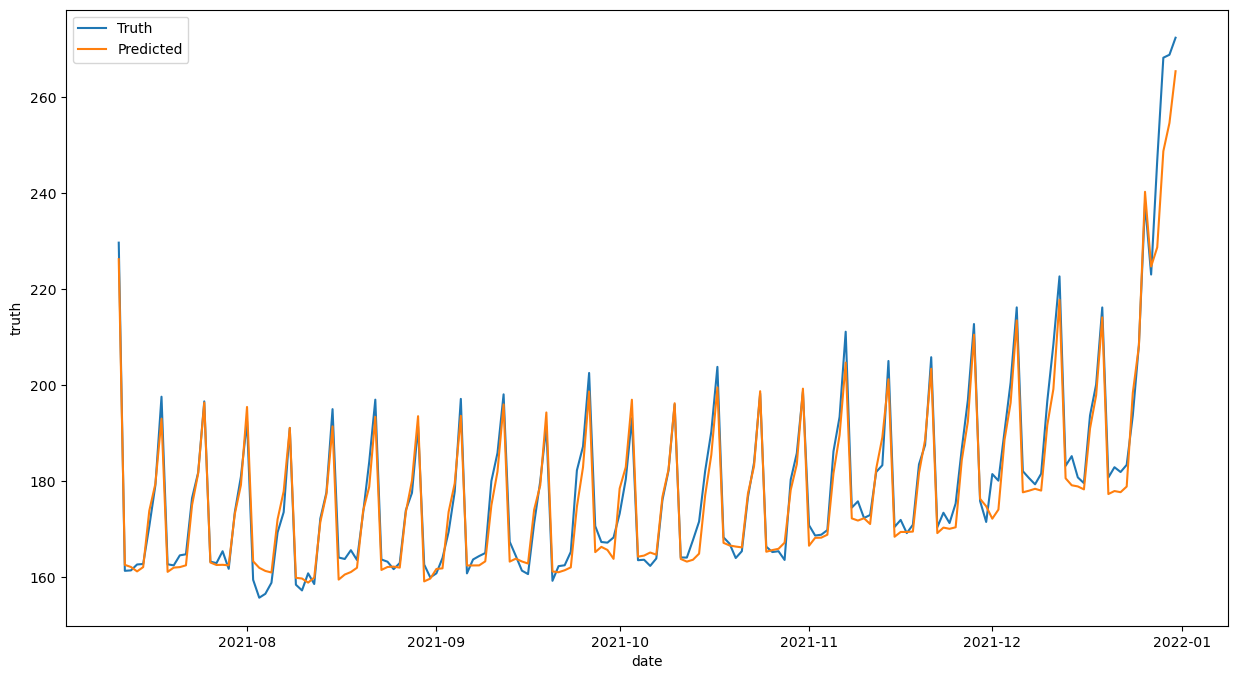

In [37]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=res, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=res, ci=None, label='Predicted')
plt.legend()

# XGBoost + Catboost

In [38]:
mean_squared_error((y_pred_xg + y_pred_cat)/2, test_y)

361.627233663359

# Parameter tunning catboost

In [ ]:
from sklearn.model_selection import GridSearchCV
# Define the hyperparameters to tune
params = {
    'iterations': [1000, 2000, 3000,4000],
    'depth': [5, 7,9,11],
}

# Create a grid search object
cat_model_lagged = CatBoostRegressor(silent=True)

grid_search = GridSearchCV(estimator=cat_model_lagged, param_grid=params, cv=5)
grid_search.fit(train_x.values, train_y.values)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [148]:
cat_model_lagged = CatBoostRegressor(silent=True, depth= 7, iterations= 3000, learning_rate=.009)

# Fit the model to the data
cat_model_lagged.fit(train_x, train_y)

In [149]:
y_pred_cat = cat_model_lagged.predict(test_x)
mse_value = mean_squared_error(y_pred_cat, test_y)
res = pd.DataFrame(zip(map(int,y_pred_cat),test_y.values), columns=["predicted", "truth"])
print(f"MSE: {mse_value}")
res.head(10)

MSE: 342.1116129075752


predicted  truth
0        140    137
1         34     35
2        682    652
3          5      5
4         25     23
5        175    166
6        138    156
7        187    185
8        123    110
9         94     93

In [150]:
mean_squared_error((y_pred_xg + y_pred_cat)/2, test_y)

357.3220936020373

# SO FAR WE CREATED LAG FIRST AND THEN DEVIDED THE DATA IN TRAIN and TEST, BUT WITH test FILE WE DO NOT HAVE THIS LAG INFORMATION AVAILABLE IN ADVANCE

# SO NOW WE FIRST MAKE PREDICTION AND THEN USE IT TO MAKE ANOTHER PREDICTION BY MAKE IT A LAG VARIABLE

In [6]:
def create_lags_for_prediction(row, predictions, no_lags): 
    for i in range(no_lags):
        row['lag_{}'.format(i+1)] = predictions[-(i+1)] 
    row['differencing'] = predictions[-1]-predictions[-2]
    for lag in [14,30,90]:
        time = pd.Series(predictions[-lag:])
        row['Rolling_Mean_{}'.format(lag)] = time.ewm(alpha=alpha).mean().iloc[-1]
        row['Rolling_Std_{}'.format(lag)] = time.ewm(alpha=alpha).std().iloc[-1]
#         row['Rolling_Min_{}'.format(lag)] = time.min()
#         row['Rolling_Max_{}'.format(lag)] = time.max()
        
#         row['Rolling_Quantile_25_{}'.format(lag)] = time.quantile(0.25)
#         row['Rolling_Quantile_50_{}'.format(lag)] = time.quantile(0.5)
#         row['Rolling_Quantile_75_{}'.format(lag)] = time.quantile(0.75)
    return row

In [7]:
def predict_group(model, data,initial_list, no_lags, result, cols):
    predictions = initial_list.copy()
    for i in range(len(data)):
        row = data.iloc[i]
        row = create_lags_for_prediction(row,predictions,no_lags)
        row = row[cols]
        y_pred = model.predict([row])[0]
        predictions.append(y_pred)
    res = pd.DataFrame(zip(result,predictions[len(initial_list):]), columns=['id', 'predicted_num_sold'])
    res.index = result.index
    return res

In [8]:
def predict(model,data,train_data,cols,no_lags):
    data = prepare_data(data)
    #train_data = prepare_data(train_data)
    countries = list(set(data['country']))
    stores = list(set(data['store']))
    products = list(set(data['product']))
    final_data = pd.DataFrame()
    for country in countries:
        for product in products:
            for store in stores:
                temp = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]
                initial_list = list(train_data[(train_data['country'] == country) & (train_data['store'] == store) & (train_data['product'] == product)]['num_sold'])
                temp = predict_group(model, temp.drop(['id'], axis=1), initial_list, no_lags, temp['id'], cols)          
                final_data = pd.concat([final_data,temp], axis=0)
                print(final_data.shape, end="")             
    return final_data

In [10]:
no_lags = 7
train_x, train_y, test_x, test_y = train_test_split(data)
train = clreate_lags_by_group(pd.concat([train_x,train_y], axis=1), lags=no_lags)
train = prepare_data(train, train_flag=True)
train_x = train.drop(['num_sold'], axis=1)
train_y = train['num_sold']

In [11]:
train_x.head()

country  store  product  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
date                                                                            
2017-04-01        3      2        2   22.0   22.0   24.0   23.0   23.0   29.0   
2017-04-01        4      2        1  105.0  103.0   97.0  102.0  113.0  138.0   
2017-04-01        0      1        0   36.0   32.0   31.0   34.0   31.0   36.0   
2017-04-01        1      1        2   17.0   16.0   18.0   16.0   17.0   20.0   
2017-04-01        2      0        2   47.0   43.0   47.0   43.0   44.0   52.0   

            lag_7  ...  Rolling_Std_30  Rolling_Mean_90  Rolling_Std_90  year  \
date               ...                                                          
2017-04-01   29.0  ...        2.352133        23.878376        2.331510  2017   
2017-04-01  114.0  ...       10.899929       108.809107       11.098335  2017   
2017-04-01   35.0  ...        3.227071        33.304304        3.300503  2017   
2017-04-01   19.0  ...        1.475722        17.381108        1.557886  2017   
2017-04-01   45.0  ...        3.112941        45.807481        3.332201  2017   

            month  quarter  week  day  DayOfWeek_sin  DayOfWeek_cos  
date                                                                 
2017-04-01      4        2     5    1      -0.974928      -0.222521  
2017-04-01      4        2     5    1      -0.974928      -0.222521  
2017-04-01      4        2     5    1      -0.974928      -0.222521  
2017-04-01      4        2     5    1      -0.974928      -0.222521  
2017-04-01      4        2     5    1      -0.974928      -0.222521  

[5 rows x 23 columns]

In [46]:
test_x.head()

id        date  country         store  \
123255  123255  2021-07-02  Estonia  Kaggle Learn   
123256  123256  2021-07-02  Estonia  Kaggle Learn   
123257  123257  2021-07-02  Estonia  Kaggle Learn   
123258  123258  2021-07-02  Estonia  Kaggle Learn   
123259  123259  2021-07-02  Estonia  Kaggle Learn   

                                               product  
123255               Using LLMs to Improve Your Coding  
123256                   Using LLMs to Train More LLMs  
123257  Using LLMs to Win Friends and Influence People  
123258      Using LLMs to Win More Kaggle Competitions  
123259                      Using LLMs to Write Better

In [47]:
# Create the XGBRegressor model
xgb_model_lagged = XGBRegressor()

# Fit the model to the data
xgb_model_lagged.fit(train_x.values, train_y.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [209]:
pred = predict(xgb_model_lagged, test_x,pd.concat([train_x,train_y],axis=1),train_x.columns, no_lags)

(182, 2)(364, 2)(546, 2)(728, 2)(910, 2)(1092, 2)(1274, 2)(1456, 2)(1638, 2)(1820, 2)(2002, 2)(2184, 2)(2366, 2)(2548, 2)(2730, 2)(2912, 2)(3094, 2)(3276, 2)(3458, 2)(3640, 2)(3822, 2)(4004, 2)(4186, 2)(4368, 2)(4550, 2)(4732, 2)(4914, 2)(5096, 2)(5278, 2)(5460, 2)(5643, 2)(5826, 2)(6009, 2)(6192, 2)(6375, 2)(6558, 2)(6741, 2)(6924, 2)(7107, 2)(7290, 2)(7473, 2)(7656, 2)(7839, 2)(8022, 2)(8205, 2)(8388, 2)(8571, 2)(8754, 2)(8937, 2)(9120, 2)(9303, 2)(9486, 2)(9669, 2)(9852, 2)(10035, 2)(10218, 2)(10401, 2)(10584, 2)(10767, 2)(10950, 2)(11133, 2)(11316, 2)(11499, 2)(11682, 2)(11865, 2)(12048, 2)(12231, 2)(12414, 2)(12597, 2)(12780, 2)(12963, 2)(13146, 2)(13329, 2)(13512, 2)(13695, 2)

In [210]:
df_merged_xg = test_x.merge(pred, on='id', how='inner')
df_merged_xg['true_num_sold'] = test_y.values

mse_value = mean_squared_error(df_merged_xg['true_num_sold'], df_merged_xg['predicted_num_sold'])
print("MSE:", mse_value)
df_merged_xg[['date','true_num_sold','predicted_num_sold']].head(5)

MSE: 1716.7855689922437


date  true_num_sold  predicted_num_sold
0 2021-07-02             80           83.074097
1 2021-07-02             69           74.435783
2 2021-07-02             12           11.874127
3 2021-07-02             57           58.687344
4 2021-07-02             60           64.240807

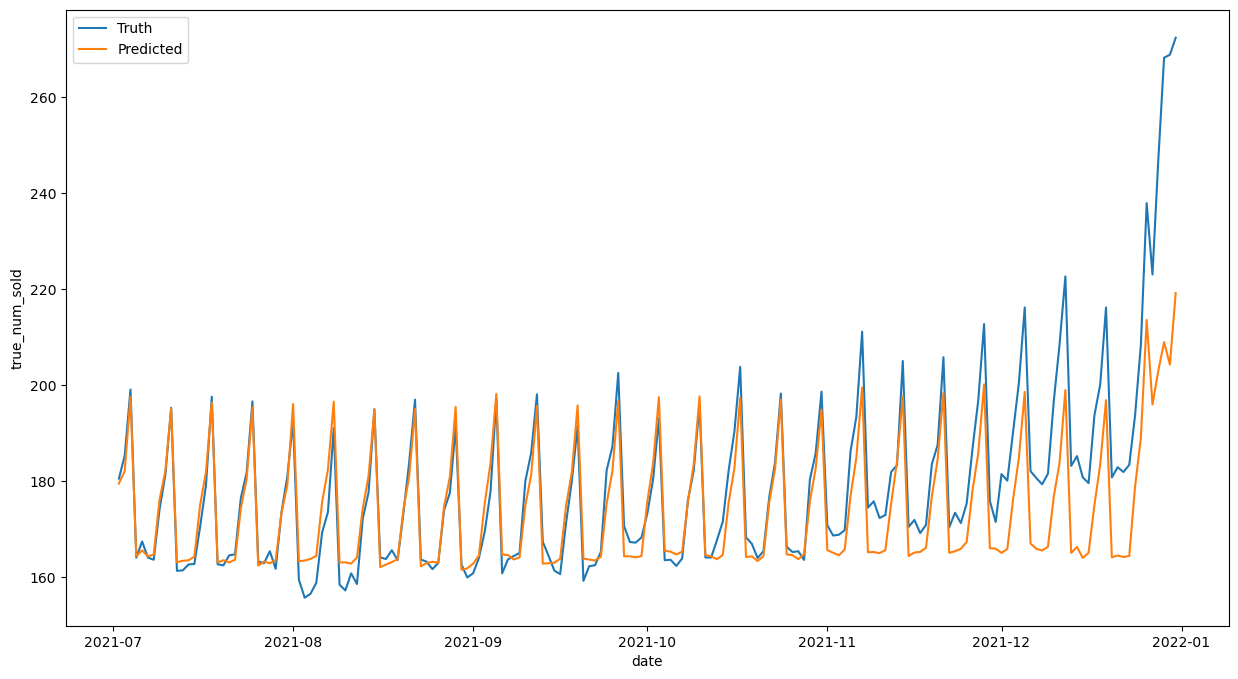

In [211]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='true_num_sold', data=df_merged_xg, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted_num_sold', data=df_merged_xg, ci=None, label='Predicted')
plt.legend()

In [221]:
result = []
for country in countries:
    for store in stores:
        for product in products:
            temp_res = df_merged_xg[(df_merged_xg['country'] == country) & (df_merged_xg['store'] == store) & (df_merged_xg['product'] == product)]
            mse = mean_squared_error(temp_res['true_num_sold'], temp_res['predicted_num_sold'])
            result.append([country, store, product, mse])
result = pd.DataFrame(result, columns=['country', 'store', 'product', 'mse'])

# Lets analyze the country, store and product with very large error

In [224]:
result[result['mse']>1000]

country         store                                     product  \
15   Canada     Kagglazon           Using LLMs to Improve Your Coding   
16   Canada     Kagglazon               Using LLMs to Train More LLMs   
18   Canada     Kagglazon  Using LLMs to Win More Kaggle Competitions   
19   Canada     Kagglazon                  Using LLMs to Write Better   
25   Canada  Kaggle Store           Using LLMs to Improve Your Coding   
28   Canada  Kaggle Store  Using LLMs to Win More Kaggle Competitions   
29   Canada  Kaggle Store                  Using LLMs to Write Better   
30  Estonia     Kagglazon           Using LLMs to Improve Your Coding   
31  Estonia     Kagglazon               Using LLMs to Train More LLMs   
33  Estonia     Kagglazon  Using LLMs to Win More Kaggle Competitions   
34  Estonia     Kagglazon                  Using LLMs to Write Better   
45    Japan     Kagglazon           Using LLMs to Improve Your Coding   
46    Japan     Kagglazon               Using LLMs to Train More LLMs   
48    Japan     Kagglazon  Using LLMs to Win More Kaggle Competitions   
49    Japan     Kagglazon                  Using LLMs to Write Better   
60    Spain     Kagglazon           Using LLMs to Improve Your Coding   
61    Spain     Kagglazon               Using LLMs to Train More LLMs   
63    Spain     Kagglazon  Using LLMs to Win More Kaggle Competitions   
64    Spain     Kagglazon                  Using LLMs to Write Better   

             mse  
15  27709.542651  
16   9186.051010  
18  13332.493869  
19   9577.764533  
25   1055.263027  
28   1229.443841  
29   1096.291404  
30  10106.006126  
31   2150.409321  
33   2945.643294  
34   4867.382256  
45   4612.087498  
46   2722.888101  
48   9380.588689  
49   2638.407332  
60   6768.955792  
61   2333.458486  
63   5042.646920  
64   2420.931264

In [56]:
def calculate_smape(true_values, predicted_values):
    smape = np.mean(2 * abs(true_values - predicted_values) / (abs(true_values) + abs(predicted_values))) * 100
    return(smape)

In [231]:
calculate_smape(df_merged_xg['true_num_sold'],df_merged_xg['predicted_num_sold'])

11.768199525137781

In [48]:
from catboost import CatBoostRegressor
# Create the XGBRegressor model
cat_model_lagged = CatBoostRegressor(silent=True, depth= 7, iterations= 3000, learning_rate=.009)

# Fit the model to the data
cat_model_lagged.fit(train_x.values, train_y.values)

pred = predict(cat_model_lagged, test_x, pd.concat([train_x,train_y],axis=1),train_x.columns, no_lags)

(182, 2)(364, 2)(546, 2)(728, 2)(910, 2)(1092, 2)(1274, 2)(1456, 2)(1638, 2)(1820, 2)(2002, 2)(2184, 2)(2366, 2)(2548, 2)(2730, 2)(2912, 2)(3094, 2)(3276, 2)(3458, 2)(3640, 2)(3822, 2)(4004, 2)(4186, 2)(4368, 2)(4550, 2)(4732, 2)(4914, 2)(5096, 2)(5278, 2)(5460, 2)(5643, 2)(5826, 2)(6009, 2)(6192, 2)(6375, 2)(6558, 2)(6741, 2)(6924, 2)(7107, 2)(7290, 2)(7473, 2)(7656, 2)(7839, 2)(8022, 2)(8205, 2)(8388, 2)(8571, 2)(8754, 2)(8937, 2)(9120, 2)(9303, 2)(9486, 2)(9669, 2)(9852, 2)(10035, 2)(10218, 2)(10401, 2)(10584, 2)(10767, 2)(10950, 2)(11133, 2)(11316, 2)(11499, 2)(11682, 2)(11865, 2)(12048, 2)(12231, 2)(12414, 2)(12597, 2)(12780, 2)(12963, 2)(13146, 2)(13329, 2)(13512, 2)(13695, 2)

In [49]:
df_merged_cat = test_x.merge(pred, on='id', how='inner')
df_merged_cat['true_num_sold'] = test_y.values

mse_value = mean_squared_error(df_merged_cat['true_num_sold'], df_merged_cat['predicted_num_sold'])
print("MSE:", mse_value)
df_merged_cat[['date','true_num_sold','predicted_num_sold']].head(5)

MSE: 1233.9946124846497


date  true_num_sold  predicted_num_sold
0 2021-07-02             80           81.377728
1 2021-07-02             69           76.697101
2 2021-07-02             12           11.984607
3 2021-07-02             57           59.816303
4 2021-07-02             60           65.653125

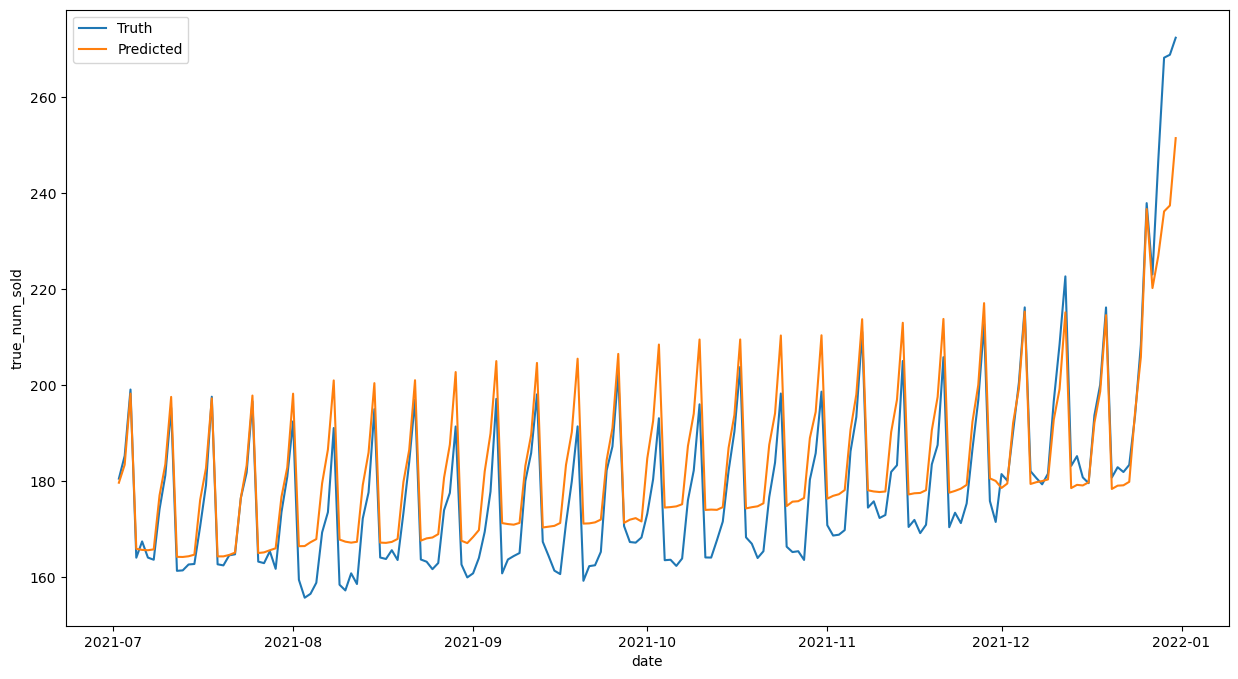

In [51]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='true_num_sold', data=df_merged_cat, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted_num_sold', data=df_merged_cat, ci=None, label='Predicted')
plt.legend()

In [53]:
result = []
for country in countries:
    for store in stores:
        for product in products:
            temp_res = df_merged_cat[(df_merged_cat['country'] == country) & (df_merged_cat['store'] == store) & (df_merged_cat['product'] == product)]
            mse = mean_squared_error(temp_res['true_num_sold'], temp_res['predicted_num_sold'])
            result.append([country, store, product, mse])
result = pd.DataFrame(result, columns=['country', 'store', 'product', 'mse'])

In [54]:
result[result['mse']>1000]

country      store                                     product  \
15   Canada  Kagglazon           Using LLMs to Improve Your Coding   
16   Canada  Kagglazon               Using LLMs to Train More LLMs   
18   Canada  Kagglazon  Using LLMs to Win More Kaggle Competitions   
19   Canada  Kagglazon                  Using LLMs to Write Better   
30  Estonia  Kagglazon           Using LLMs to Improve Your Coding   
31  Estonia  Kagglazon               Using LLMs to Train More LLMs   
33  Estonia  Kagglazon  Using LLMs to Win More Kaggle Competitions   
34  Estonia  Kagglazon                  Using LLMs to Write Better   
45    Japan  Kagglazon           Using LLMs to Improve Your Coding   
46    Japan  Kagglazon               Using LLMs to Train More LLMs   
48    Japan  Kagglazon  Using LLMs to Win More Kaggle Competitions   
49    Japan  Kagglazon                  Using LLMs to Write Better   
60    Spain  Kagglazon           Using LLMs to Improve Your Coding   
61    Spain  Kagglazon               Using LLMs to Train More LLMs   
63    Spain  Kagglazon  Using LLMs to Win More Kaggle Competitions   
64    Spain  Kagglazon                  Using LLMs to Write Better   

             mse  
15  18567.497295  
16   7512.661844  
18   6172.010062  
19   7097.523007  
30   8591.532302  
31   7939.632108  
33   1846.222399  
34   4722.613880  
45   2095.581398  
46   3358.672470  
48   1356.544940  
49   7023.701144  
60   2217.580167  
61   1300.911890  
63   3719.175802  
64   1928.721742

In [57]:
calculate_smape(df_merged_cat['true_num_sold'],df_merged_cat['predicted_num_sold'])

10.210289124181148

# XGBoost + Catboost

In [ ]:
ens = pd.DataFrame()
ens['true_num_sold'] = df_merged_xg['true_num_sold']
ens['date'] = df_merged_xg['date']
ens['predicted_num_sold'] = (df_merged_xg['predicted_num_sold'] + df_merged_cat['predicted_num_sold'])/2
mean_squared_error(ens['predicted_num_sold'],ens['true_num_sold'])

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='true_num_sold', data=ens, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted_num_sold', data=ens, ci=None, label='Predicted')
plt.legend()

# Final Prediction on whole data

In [16]:
no_lags = 7
train = clreate_lags_by_group(data, lags=no_lags)
train = prepare_data(train, train_flag=True)
train_x = train.drop(['num_sold'], axis=1)
train_y = train['num_sold']

In [93]:
# Create the XGBRegressor model
xgb_model_lagged_final = XGBRegressor()

# Fit the model to the data
xgb_model_lagged_final.fit(train_x.values, train_y.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
final_xgb_submission = predict(xgb_model_lagged_final, test, pd.concat([train_x,train_y],axis=1),train_x.columns, no_lags)

In [ ]:
final_xgb_submission_merged = test.merge(final_xgb_submission, on='id', how='inner')
final_xgb_submission_merged = final_xgb_submission_merged[['id', 'predicted_num_sold']]
final_xgb_submission_merged['num_sold'] = final_xgb_submission_merged['predicted_num_sold']

In [ ]:
final_xgb_submission_merged.head(10)

In [ ]:
final_xgb_submission_merged = final_xgb_submission_merged[['id', 'num_sold']]
final_xgb_submission_merged.to_csv("submission.csv", index=False)

In [17]:
from catboost import CatBoostRegressor
# Create the XGBRegressor model
final_cat_model_lagged = CatBoostRegressor(silent=True, depth= 7, iterations= 3000, learning_rate=.009)

# Fit the model to the data
final_cat_model_lagged.fit(train_x.values, train_y.values)

final_cat_boost_submission = predict(final_cat_model_lagged, test, pd.concat([train_x,train_y],axis=1),train_x.columns, no_lags)

(365, 2)(730, 2)(1095, 2)(1460, 2)(1825, 2)(2190, 2)(2555, 2)(2920, 2)(3285, 2)(3650, 2)(4015, 2)(4380, 2)(4745, 2)(5110, 2)(5475, 2)(5840, 2)(6205, 2)(6570, 2)(6935, 2)(7300, 2)(7665, 2)(8030, 2)(8395, 2)(8760, 2)(9125, 2)(9490, 2)(9855, 2)(10220, 2)(10585, 2)(10950, 2)(11315, 2)(11680, 2)(12045, 2)(12410, 2)(12775, 2)(13140, 2)(13505, 2)(13870, 2)(14235, 2)(14600, 2)(14965, 2)(15330, 2)(15695, 2)(16060, 2)(16425, 2)(16790, 2)(17155, 2)(17520, 2)(17885, 2)(18250, 2)(18615, 2)(18980, 2)(19345, 2)(19710, 2)(20075, 2)(20440, 2)(20805, 2)(21170, 2)(21535, 2)(21900, 2)(22265, 2)(22630, 2)(22995, 2)(23360, 2)(23725, 2)(24090, 2)(24455, 2)(24820, 2)(25185, 2)(25550, 2)(25915, 2)(26280, 2)(26645, 2)(27010, 2)(27375, 2)

In [19]:
final_cat_boost_submission_merged = test.merge(final_cat_boost_submission, on='id', how='inner')
final_cat_boost_submission_merged = final_cat_boost_submission_merged[['id', 'predicted_num_sold']]
final_cat_boost_submission_merged['num_sold'] = final_cat_boost_submission_merged['predicted_num_sold']

In [20]:
final_cat_boost_submission_merged = final_cat_boost_submission_merged[['id', 'num_sold']]
final_cat_boost_submission_merged.to_csv("submission.csv", index=False)

# Using Facebook Prophet

In [91]:
import logging
import pandas as pd
import prophet
from prophet import Prophet

In [95]:
logging.getLogger('prophet').setLevel(logging.ERROR)

In [11]:
data = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
data['date'] = pd.to_datetime(data['date'])
test = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")

In [164]:
def predict_from_prophet(train, test):
    data = pd.DataFrame()
    data['ds'] = pd.to_datetime(train['date'])
    data['y'] = train['num_sold']
    prophet_model = prophet.Prophet(seasonality_mode='additive',
                                    yearly_seasonality=45,
                                    seasonality_prior_scale=0.004,
                                    #changepoint_prior_scale=0.003,
                                    changepoints=[pd.to_datetime("2020-04-09")]
                                   )
    prophet_model.fit(data)
    future = prophet_model.make_future_dataframe(periods=len(test))
    forecast = prophet_model.predict(future)
    y_pred = forecast['yhat'][-len(test):]
    y_pred.index = test.index
    return y_pred

In [155]:
result = pd.DataFrame()
for country in countries:
    for store in stores:
        for product in products:
            temp = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]
            train_x, train_y, test_x, test_y = train_test_split(temp)
            y_pred = predict_from_prophet(pd.concat([train_x, train_y],axis=1), test_x)
            test_x['predicted'] = y_pred
            test_x['truth'] = test_y
            result = result.append(test_x)
            
mse = mean_squared_error(result['predicted'], result['truth'])
print(mse)
print(result.shape)

14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:29 - cmdstanpy - INFO - Chain [1] done processing
14:55:30 - cmdstanpy - INFO - Chain [1] start processing
14:55:30 - cmdstanpy - INFO - Chain [1] done processing
14:55:31 - cmdstanpy - INFO - Chain [1] start processing
14:55:32 - cmdstanpy - INFO - Chain [1] done processing
14:55:33 - cmdstanpy - INFO - Chain [1] start processing
14:55:33 - cmdstanpy - INFO - Chain [1] done processing
14:55:34 - cmdstanpy - INFO - Chain [1] start processing
14:55:34 - cmdstanpy - INFO - Chain [1] done processing
14:55:36 - cmdstanpy - INFO - Chain [1] start processing
14:55:36 - cmdstanpy - INFO - Chain [1] done processing
14:55:37 - cmdstanpy - INFO - Chain [1] start processing
14:55:37 - cmdstanpy - INFO - Chain [1] done processing
14:55:39 - cmdstanpy - INFO - Chain [1] start processing
14:55:39 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1]

507.9955038715927
(13725, 7)


In [156]:
result.sort_values(by='date')

id       date    country         store  \
123235  123235 2021-07-02  Argentina     Kagglazon   
123291  123291 2021-07-02      Spain  Kaggle Store   
123293  123293 2021-07-02      Spain  Kaggle Store   
123246  123246 2021-07-02     Canada  Kaggle Store   
123284  123284 2021-07-02      Japan     Kagglazon   
...        ...        ...        ...           ...   
136897  136897 2021-12-31     Canada  Kaggle Store   
136921  136921 2021-12-31      Japan  Kaggle Learn   
136892  136892 2021-12-31     Canada  Kaggle Learn   
136925  136925 2021-12-31      Japan  Kaggle Store   
136944  136944 2021-12-31      Spain  Kaggle Store   

                                               product   predicted  truth  
123235               Using LLMs to Improve Your Coding  163.662643    166  
123291                   Using LLMs to Train More LLMs  115.571819    120  
123293      Using LLMs to Win More Kaggle Competitions   92.786583    101  
123246                   Using LLMs to Train More LLMs  205.588195    194  
123284                      Using LLMs to Write Better  483.374370    525  
...                                                ...         ...    ...  
136897  Using LLMs to Win Friends and Influence People   46.052985     61  
136921                   Using LLMs to Train More LLMs  106.948947    115  
136892  Using LLMs to Win Friends and Influence People   30.210907     36  
136925               Using LLMs to Improve Your Coding  179.069305    176  
136944                      Using LLMs to Write Better  135.440811    139  

[13725 rows x 7 columns]

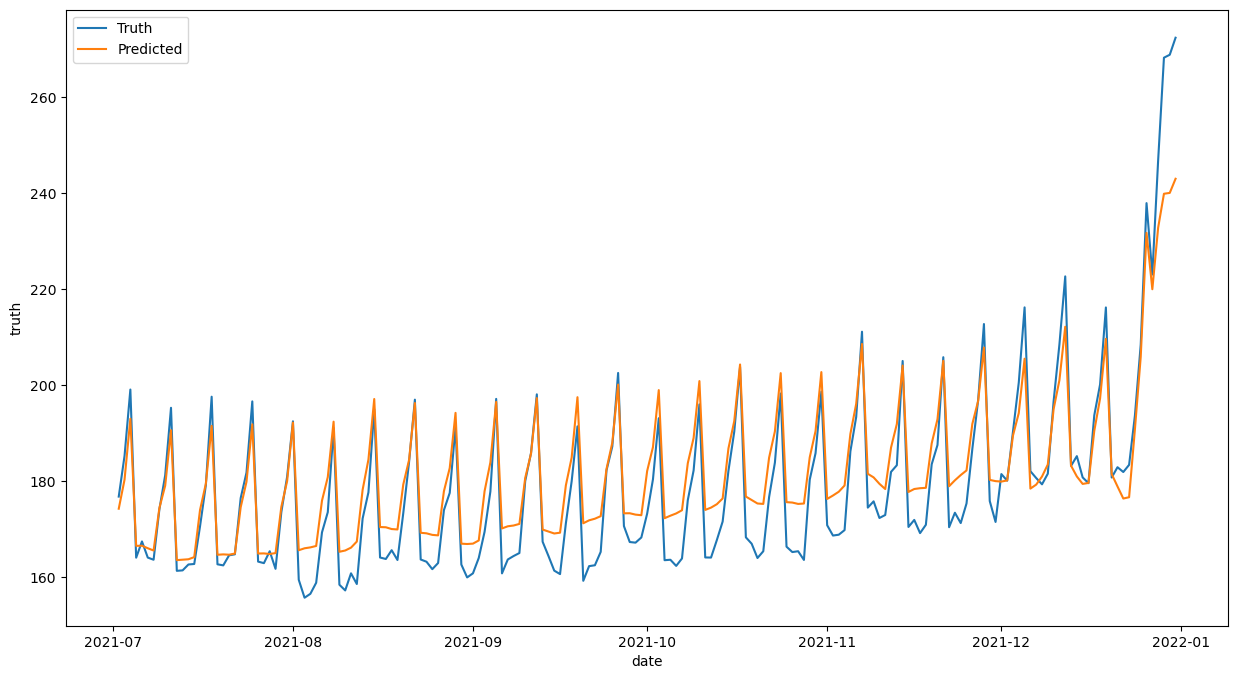

In [158]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='truth', data=result, ci=None, label='Truth')
sns.lineplot(x='date', y='predicted', data=result, ci=None, label='Predicted')
plt.legend()

# Final prediction whole dataset using FB_Prophet

In [174]:
def predict_from_prophet(train, test):
    data = pd.DataFrame()
    data['ds'] = pd.to_datetime(train['date'])
    data['y'] = train['num_sold']
    prophet_model = prophet.Prophet(seasonality_mode='additive',
                                    yearly_seasonality=45,
                                    seasonality_prior_scale=0.004,
                                    #changepoint_prior_scale=0.003,
                                    changepoints=[pd.to_datetime("2020-04-09")]
                                   )
    prophet_model.fit(data)
    future = prophet_model.make_future_dataframe(periods=len(test))
    forecast = prophet_model.predict(future)
    y_pred = forecast['yhat'][-len(test):]
    y_pred.index = test.index
    return y_pred

In [176]:
data = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
data['date'] = pd.to_datetime(data['date'])
test = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")

final_result = pd.DataFrame()
for country in countries:
    for store in stores:
        for product in products:
            temp_train_data = data[(data['country'] == country) & (data['store'] == store) & (data['product'] == product)]
            temp_test_data = test[(test['country'] == country) & (test['store'] == store) & (test['product'] == product)]
            y_pred = predict_from_prophet(temp_train_data, test=temp_test_data)
            temp_test_data['num_sold'] = y_pred
            final_result = final_result.append(temp_test_data)
            
final_result.head(2)

15:09:40 - cmdstanpy - INFO - Chain [1] start processing
15:09:40 - cmdstanpy - INFO - Chain [1] done processing
15:09:42 - cmdstanpy - INFO - Chain [1] start processing
15:09:42 - cmdstanpy - INFO - Chain [1] done processing
15:09:43 - cmdstanpy - INFO - Chain [1] start processing
15:09:44 - cmdstanpy - INFO - Chain [1] done processing
15:09:46 - cmdstanpy - INFO - Chain [1] start processing
15:09:46 - cmdstanpy - INFO - Chain [1] done processing
15:09:47 - cmdstanpy - INFO - Chain [1] start processing
15:09:47 - cmdstanpy - INFO - Chain [1] done processing
15:09:49 - cmdstanpy - INFO - Chain [1] start processing
15:09:49 - cmdstanpy - INFO - Chain [1] done processing
15:09:50 - cmdstanpy - INFO - Chain [1] start processing
15:09:50 - cmdstanpy - INFO - Chain [1] done processing
15:09:52 - cmdstanpy - INFO - Chain [1] start processing
15:09:52 - cmdstanpy - INFO - Chain [1] done processing
15:09:53 - cmdstanpy - INFO - Chain [1] start processing
15:09:53 - cmdstanpy - INFO - Chain [1]

id        date    country      store  \
10  136960  2022-01-01  Argentina  Kagglazon   
85  137035  2022-01-02  Argentina  Kagglazon   

                              product    num_sold  
10  Using LLMs to Improve Your Coding  234.852661  
85  Using LLMs to Improve Your Coding  222.440638

In [180]:
final_result.isnull().any()

id          False
num_sold    False
dtype: bool

In [181]:
len(test), len(final_result)

(27375, 27375)

In [178]:
final_result = final_result.sort_values(by='id')[['id','num_sold']]
final_result.to_csv("submission.csv", index=False)

In [179]:
final_result.head()

id   num_sold
0  136950  40.410837
1  136951  39.648851
2  136952   5.904057
3  136953  38.212048
4  136954  31.314633

In [ ]:
d